In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import random
import json
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def convert_xml_to_json_vrp4_standard_no_tw(
    path_xml,
    path_json_out,
    n_depots=3,
    n_vendors=None,
    n_markets=None,
    commodities=None,
    depot_capacity_factor=1.2,
    balance_factor=0.8,
    magnitude_factor=5.0,
    depot_selection="kmeans", 
    seed=42
):

    if commodities is None:
        commodities = ["food", "drink", "electronics", "household"]

    commodity_to_idx = {c: i for i, c in enumerate(commodities)}
    rng = random.Random(seed)
    np.random.seed(seed)

    # --- Load XML ---
    tree = ET.parse(path_xml)
    root = tree.getroot()

    nodes = []
    for node in root.findall("NodeP"):
        nodes.append({
            "id": int(node.find("id").text),
            "coord_x": float(node.find("CoordX").text),
            "coord_y": float(node.find("CoordY").text),
        })

    df = pd.DataFrame(nodes).sort_values("id").reset_index(drop=True)
    n_total = len(df)
    coords = df[["coord_x", "coord_y"]].values

    if n_vendors is None or n_markets is None:
        remaining = n_total - n_depots
        # (EDIT) Thay đổi tỉ lệ mặc định thành 40% vendors / 60% markets
        n_vendors = int(np.round(remaining * 0.4))
        n_markets = remaining - n_vendors
        print(f"n_vendors/n_markets not specified. Using default 40V/60M split: {n_vendors}V / {n_markets}M")


    assert n_depots + n_vendors + n_markets <= n_total, (
        f"Sum depots+vendors+markets ({n_depots+n_vendors+n_markets}) > total nodes ({n_total})."
    )
    
    # Khởi tạo vendor_ids và market_ids, sẽ được gán bên dưới
    vendor_ids = []
    market_ids = []

    # --- Chọn depot ---
    if depot_selection == "random":
        depot_indices = rng.sample(range(n_total), n_depots)
        
    elif depot_selection == "spread":
        depot_indices = [rng.randrange(n_total)]
        while len(depot_indices) < n_depots:
            dists = np.min([np.linalg.norm(coords - coords[i], axis=1) for i in depot_indices], axis=0)
            for i in depot_indices: dists[i] = -1
            next_idx = int(np.argmax(dists)); depot_indices.append(next_idx)
            
    elif depot_selection == "maxsum":
        depot_indices = [rng.randrange(n_total)]
        while len(depot_indices) < n_depots:
            dists = np.sum([np.linalg.norm(coords - coords[i], axis=1) for i in depot_indices], axis=0)
            for i in depot_indices: dists[i] = -1
            next_idx = int(np.argmax(dists)); depot_indices.append(next_idx)
            
    elif depot_selection == "outlier":
        dist_matrix = cdist(coords, coords)
        mean_dists = np.mean(dist_matrix, axis=1)
        depot_indices = np.argsort(mean_dists)[-n_depots:].tolist()
        
    elif depot_selection == "kmeans":
        kmeans = KMeans(n_clusters=n_depots, random_state=seed, n_init=10)
        kmeans.fit(coords)
        centers = kmeans.cluster_centers_
        labels = kmeans.labels_ # (NEW) Lấy nhãn cluster cho tất cả các node
        
        depot_indices = []
        # Tìm node gần nhất với mỗi tâm cụm
        for center in centers:
            dists_to_center = np.linalg.norm(coords - center, axis=1)
            # Tránh chọn lại node đã là depot
            for idx in depot_indices: dists_to_center[idx] = np.inf
            closest_idx = int(np.argmin(dists_to_center))
            depot_indices.append(closest_idx)
            
        # --- (NEW) Phân vendor/market TỶ LỆ theo cluster ---
        print("KMeans selected. Assigning vendors/markets proportionally to clusters.")
        all_indices = list(range(n_total))
        remaining_indices = [i for i in all_indices if i not in depot_indices]
        
        total_remaining_needed = n_vendors + n_markets
        
        # Kiểm tra nếu số node còn lại khớp với tổng V/M mong muốn
        if len(remaining_indices) != total_remaining_needed:
            print(f"Warning: Node mismatch. Remaining indices {len(remaining_indices)} != n_vendors+n_markets {total_remaining_needed}")
            print("Fallback to random assignment.")
            rng.shuffle(remaining_indices)
            vendor_indices = remaining_indices[:n_vendors]
            market_indices = remaining_indices[n_vendors:]
            vendor_ids = df.loc[vendor_indices, "id"].tolist()
            market_ids = df.loc[market_indices, "id"].tolist()
        
        else:
            # (NEW) Logic chia tỷ lệ (Apportionment)
            n_remaining_in_cluster = {k: 0 for k in range(n_depots)}
            remaining_indices_by_cluster = {k: [] for k in range(n_depots)}
            
            for i in remaining_indices:
                k = labels[i] # Lấy nhãn cluster của node index i
                n_remaining_in_cluster[k] += 1
                remaining_indices_by_cluster[k].append(i)
                
            vendor_fraction = 0
            if (n_vendors + n_markets) > 0:
                vendor_fraction = n_vendors / (n_vendors + n_markets)
            
            # Tính số vendor mục tiêu (có thể lẻ)
            target_vendors_in_cluster = {k: n_remaining_in_cluster[k] * vendor_fraction for k in range(n_depots)}
            # Gán số vendor ban đầu (phần nguyên)
            initial_vendors_in_cluster = {k: int(np.floor(target_vendors_in_cluster[k])) for k in range(n_depots)}
            total_initial_vendors = sum(initial_vendors_in_cluster.values())
            
            # Tính số vendor còn thiếu (nếu dương) hoặc thừa (nếu âm)
            shortfall = n_vendors - total_initial_vendors
            
            # Tính phần dư
            remainders = {k: target_vendors_in_cluster[k] - initial_vendors_in_cluster[k] for k in range(n_depots)}
            
            final_vendors_in_cluster = initial_vendors_in_cluster.copy()

            if shortfall > 0:
                # Cần thêm 'shortfall' vendors
                # Ưu tiên các cluster có phần dư lớn nhất
                clusters_sorted_by_remainder = sorted(remainders.keys(), key=lambda k: remainders[k], reverse=True)
                for i in range(shortfall):
                    k_to_add = clusters_sorted_by_remainder[i]
                    final_vendors_in_cluster[k_to_add] += 1
            elif shortfall < 0:
                # Cần bớt 'abs(shortfall)' vendors
                overshoot = abs(shortfall)
                # Bớt ở các cluster có phần dư nhỏ nhất
                clusters_sorted_by_remainder = sorted(remainders.keys(), key=lambda k: remainders[k], reverse=False)
                for i in range(overshoot):
                    k_to_remove = clusters_sorted_by_remainder[i]
                    final_vendors_in_cluster[k_to_remove] -= 1
            
            # (NEW) Gán vendor/market dựa trên số lượng đã tính
            vendor_ids = []
            market_ids = []
            for k in range(n_depots):
                n_vendors_k = final_vendors_in_cluster[k]
                if n_vendors_k < 0: n_vendors_k = 0 # Đề phòng
                
                indices_for_this_cluster = remaining_indices_by_cluster[k]
                rng.shuffle(indices_for_this_cluster)
                
                vendor_indices_k = indices_for_this_cluster[:n_vendors_k]
                market_indices_k = indices_for_this_cluster[n_vendors_k:]
                
                vendor_ids.extend(df.loc[vendor_indices_k, "id"].tolist())
                market_ids.extend(df.loc[market_indices_k, "id"].tolist())

            # (NEW) Kiểm tra lại
            if len(vendor_ids) != n_vendors:
                 print(f"Warning: Final vendor count mismatch. Got {len(vendor_ids)}, expected {n_vendors}")
            if len(market_ids) != n_markets:
                 print(f"Warning: Final market count mismatch. Got {len(market_ids)}, expected {n_markets}")
            
    else:
        raise ValueError("depot_selection must be 'random', 'spread', 'maxsum', 'kmeans', or 'outlier'")

    depot_ids = df.loc[depot_indices, "id"].tolist()

    # --- (MODIFIED) Phân vendor/market ---
    # Chỉ chạy khối này nếu KHÔNG phải là 'kmeans' (vì kmeans đã xử lý ở trên)
    if depot_selection != "kmeans":
        print(f"Selection method is '{depot_selection}'. Assigning vendors/markets randomly.")
        remaining_ids = [nid for nid in df["id"] if nid not in depot_ids]
        rng.shuffle(remaining_ids)
        vendor_ids = remaining_ids[:n_vendors]
        market_ids = remaining_ids[n_vendors:n_vendors + n_markets]

    # --- Sinh dữ liệu hàng hoá ---
    vendor_data = [{c: round(rng.uniform(3, 12), 1) for c in commodities} for _ in range(n_vendors)]
    market_data = [{c: round(rng.uniform(2, 10), 1) for c in commodities} for _ in range(n_markets)]

    total_vendor = {c: sum(v[c] for v in vendor_data) for c in commodities}
    total_market = {c: sum(m[c] for m in market_data) for c in commodities}

    # Giới hạn cầu market ≤ cung * balance_factor
    for c in commodities:
        max_market_c = total_vendor[c] * balance_factor
        if total_market[c] > max_market_c and total_market[c] > 0:
            scale = max_market_c / total_market[c]
            for m in market_data:
                m[c] = round(m[c] * scale, 1)

    # Khuếch đại độ lớn bài toán
    for v in vendor_data:
        for c in commodities:
            v[c] = round(v[c] * magnitude_factor, 1)
    for m in market_data:
        for c in commodities:
            m[c] = round(m[c] * magnitude_factor, 1)

    total_vendor = {c: round(sum(v[c] for v in vendor_data), 1) for c in commodities}
    total_market = {c: round(sum(m[c] for m in market_data), 1) for c in commodities}

    # --- Sức chứa depot tổng & chia đều ---
    depot_capacity_total = {c: round(total_market[c] * 1.2, 1) for c in commodities}
    depot_capacity = {
        c: round((depot_capacity_total[c] / n_depots) * depot_capacity_factor, 1)
        for c in commodities
    }

    # --- Build node_data ---
    node_data = []
    v_idx, m_idx = 0, 0
    id_set = set(depot_ids) | set(vendor_ids) | set(market_ids)

    for _, row in df.iterrows():
        node_id = int(row["id"])
        if node_id not in id_set: 
            continue

        if node_id in depot_ids:
            cap_dict = depot_capacity
            cap_vec = [cap_dict[c] for c in commodities]
            node_data.append({
                "id": node_id,
                "type": "depot",
                "coord_x": row["coord_x"],
                "coord_y": row["coord_y"],
                "storage_capacity_dict": cap_dict,
                "storage_capacity_vec": cap_vec,
                # "time_window": ... (ĐÃ XÓA)
                # "service_time": ... (ĐÃ XÓA)
            })

        elif node_id in vendor_ids:
            if v_idx >= len(vendor_data):
                print(f"Error: v_idx {v_idx} out of bounds for vendor_data {len(vendor_data)}")
                continue
            v = vendor_data[v_idx]; v_idx += 1
            v_vec = [v[c] for c in commodities]
            node_data.append({
                "id": node_id,
                "type": "vendor",
                "coord_x": row["coord_x"],
                "coord_y": row["coord_y"],
                "collected_goods_dict": v,
                "collected_goods_vec": v_vec,
                "total_goods": round(sum(v.values()), 1),
                # "time_window": ... (ĐÃ XÓA)
                # "service_time": ... (ĐÃ XÓA)
            })

        else: # market
            if m_idx >= len(market_data):
                print(f"Error: m_idx {m_idx} out of bounds for market_data {len(market_data)}")
                continue
            m = market_data[m_idx]; m_idx += 1
            m_vec = [m[c] for c in commodities]
            node_data.append({
                "id": node_id,
                "type": "market",
                "coord_x": row["coord_x"],
                "coord_y": row["coord_y"],
                "order_dict": m,
                "order_vec": m_vec,
                "total_order": round(sum(m.values()), 1),
                # "time_window": ... (ĐÃ XÓA)
                # "service_time": ... (ĐÃ XÓA)
            })

    data = {
        "meta": {
            "total_nodes": len(node_data),
            "n_depots": n_depots,
            "n_vendors": n_vendors,
            "n_markets": n_markets,
            "commodities": commodities,
            "commodity_to_idx": commodity_to_idx,
            "depot_capacity_factor": depot_capacity_factor,
            "balance_factor": balance_factor,
            "magnitude_factor": magnitude_factor,
            "depot_selection": depot_selection,
            # "time_unit": ... (ĐÃ XÓA)
        },
        "nodes": node_data
    }

    with open(path_json_out, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2)

    total_depot_capacity = {c: round(depot_capacity[c] * n_depots, 1) for c in commodities}

    print(f"✅ JSON (No TW) saved to {path_json_out}")
    print(f"🏭 Depot selection method: {depot_selection}")
    print(f"🏭 Depots ({len(depot_ids)}): {depot_ids}")
    print(f"🏬 Vendors ({len(vendor_ids)}): {len(vendor_ids)} nodes") # Rút gọn
    print(f"🏪 Markets ({len(market_ids)}): {len(market_ids)} nodes") # Rút gọn
    print("📦 Tổng cung vendor:", total_vendor)
    print("🛒 Tổng cầu market:", total_market)
    print("🏢 Tổng sức chứa depot:", total_depot_capacity)
    print("📊 Depot capacity mỗi kho:", depot_capacity)

In [2]:
if __name__ == "__main__":
    convert_xml_to_json_vrp4_standard_no_tw(
        path_xml=r"C:\Users\thaip\Desktop\VRP4\data\instances (english version)\Osaba_100_1.xml",
        path_json_out=r"C:\Users\thaip\Desktop\VRP4\data\JSON\osaba-100-instances\osaba_100_standard.json",
        n_depots=10,
        n_vendors=None,
        n_markets=None,
        commodities=["food", "drink", "electronics", "household"],
        depot_capacity_factor=1.2,
        balance_factor=0.95,
        magnitude_factor=5.0,
        depot_selection="kmeans", # Đổi mặc định thành kmeans
        seed=42
    )

n_vendors/n_markets not specified. Using default 40V/60M split: 36V / 55M
KMeans selected. Assigning vendors/markets proportionally to clusters.
✅ JSON (No TW) saved to C:\Users\thaip\Desktop\VRP4\data\JSON\osaba-100-instances\osaba_100_standard.json
🏭 Depot selection method: kmeans
🏭 Depots (10): [38, 94, 6, 74, 45, 66, 15, 85, 56, 26]
🏬 Vendors (36): 36 nodes
🏪 Markets (55): 55 nodes
📦 Tổng cung vendor: {'food': 1372.5, 'drink': 1357.5, 'electronics': 1330.5, 'household': 1354.0}
🛒 Tổng cầu market: {'food': 1304.5, 'drink': 1288.5, 'electronics': 1262.0, 'household': 1287.0}
🏢 Tổng sức chứa depot: {'food': 1878.0, 'drink': 1855.0, 'electronics': 1817.0, 'household': 1853.0}
📊 Depot capacity mỗi kho: {'food': 187.8, 'drink': 185.5, 'electronics': 181.7, 'household': 185.3}


In [3]:
import xml.etree.ElementTree as ET
import json
import os
import math

def extract_edges_from_vrp4(xml_path, json_out_path):
    """
    Trích xuất danh sách cạnh từ file XML VRP4.
    Đọc các node và các kết nối hợp lệ (hoặc cấm), 
    tính khoảng cách Manhattan và lưu ra JSON.
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    nodes = []
    for node in root.findall("NodeP"):
        node_id = int(node.find("id").text)
        x = float(node.find("CoordX").text)
        y = float(node.find("CoordY").text)
        nodes.append({"id": node_id, "x": x, "y": y})
    n = len(nodes)
    print(f"📍 Có {n} đỉnh")
    
    # Sắp xếp các node theo 'id' để đảm bảo chỉ số (index) 0..n-1
    # khớp với node id 1..n (hoặc 0..n-1)
    # Giả sử file XML có id node từ 1 đến n
    nodes.sort(key=lambda n: n['id'])
    
    # Tạo map từ id (ví dụ: 100) sang index (ví dụ: 99)
    # Tuy nhiên, code bên dưới lại giả định index 0..n-1
    # Chúng ta sẽ dùng index 0..n-1 cho đơn giản.
    
    # Kiểm tra xem id có bắt đầu từ 0 hay 1
    min_id = min(n['id'] for n in nodes)
    max_id = max(n['id'] for n in nodes)
    id_offset = 0
    if min_id == 1 and max_id == n:
        id_offset = 1 # ID là 1..n, index sẽ là 0..n-1
        print(f"ℹ️ ID node chạy từ 1 đến {n}. Sẽ chuyển về index 0..{n-1}.")
    elif min_id == 0 and max_id == n - 1:
        id_offset = 0 # ID là 0..n-1
        print(f"ℹ️ ID node chạy từ 0 đến {n-1}. Giữ nguyên index 0..{n-1}.")
    else:
        print(f"⚠️ Cảnh báo: ID node không liên tục (min={min_id}, max={max_id}). Giả sử ID = Index.")


    arcs = root.findall(".//Arco")
    edges_p = root.findall(".//EdgeP")
    conn = root.find(".//ConnectivityMatrix")
    prohib = root.findall(".//Prohibido")

    edges = []

    def manhattan(a,b): return abs(a["x"]-b["x"]) + abs(a["y"]-b["y"])

    if arcs or edges_p:
        edge_elements = arcs if arcs else edges_p
        for e in edge_elements:
            i_id = int(e.find("from").text)
            j_id = int(e.find("to").text)
            
            i = i_id - id_offset
            j = j_id - id_offset
            
            if 0 <= i < n and 0 <= j < n:
                dist = round(manhattan(nodes[i], nodes[j]), 2)
                edges.append({"from": i, "to": j, "distance": dist})
        print(f"✅ Đọc được {len(edges)} cạnh từ thẻ Arco/EdgeP")

    elif conn is not None:
        rows = conn.findall("row")
        for i, row in enumerate(rows):
            values = [int(v) for v in row.text.strip().split()]
            for j, v in enumerate(values):
                if v == 1 and i != j:
                    dist = round(manhattan(nodes[i], nodes[j]), 2)
                    edges.append({"from": i, "to": j, "distance": dist})
        print(f"✅ Đọc được {len(edges)} cạnh từ ConnectivityMatrix")

    else:
        print(f"ℹ️ Không tìm thấy Arco, EdgeP, hay ConnectivityMatrix. " \
              f"Tạo đồ thị đầy đủ và loại trừ các cạnh 'Prohibido' (cấm).")
        forbidden = set()
        for p in prohib:
            a = p.find("est1"); b = p.find("est2")
            if a is not None and b is not None:
                i_id, j_id = int(a.text), int(b.text)
                i = i_id - id_offset
                j = j_id - id_offset
                forbidden.add((i, j)); forbidden.add((j, i))
        print(f"🚫 Tìm thấy {len(forbidden)//2} cạnh cấm.")

        for i in range(n):
            for j in range(i + 1, n): # Chỉ lặp nửa ma trận
                if (i, j) not in forbidden:
                    dist = round(manhattan(nodes[i], nodes[j]), 2)
                    # Thêm cả hai chiều (hoặc chỉ một nếu đồ thị có hướng, 
                    # nhưng ở đây ta làm ma trận đối xứng)
                    edges.append({"from": i, "to": j, "distance": dist})
                    edges.append({"from": j, "to": i, "distance": dist})
        print(f"✅ Đã tạo {len(edges)} cạnh (đầy đủ, trừ cạnh cấm).")


    os.makedirs(os.path.dirname(json_out_path), exist_ok=True)
    data = {"type": "edge_list", "n_nodes": n, "edges": edges}
    with open(json_out_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2)
    print(f"💾 Đã lưu danh sách cạnh vào: {json_out_path}")


def build_adjacency_from_edge_json(edge_json_path, out_json_path):
    """
    Đọc file JSON danh sách cạnh và xây dựng
    ma trận kề (adjacency_matrix) và ma trận khoảng cách (distance_matrix).
    """
    # --- 1️⃣ Load edge list ---
    with open(edge_json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    edges = data["edges"]
    n = data["n_nodes"]

    print(f"📦 Đọc {len(edges)} cạnh từ {edge_json_path}")
    print(f"📍 Tổng số node: {n}")

    # --- 2️⃣ Khởi tạo ma trận ---
    adjacency = [[0 for _ in range(n)] for _ in range(n)]
    distance = [[float("inf") for _ in range(n)] for _ in range(n)]

    # --- 3️⃣ Gán giá trị cho các cạnh hợp lệ ---
    valid_edge_count = 0
    for e in edges:
        i, j, d = e["from"], e["to"], e["distance"]
        if 0 <= i < n and 0 <= j < n:
            if adjacency[i][j] == 0: # Chỉ đếm nếu là cạnh mới
                valid_edge_count += 1
            
            adjacency[i][j] = 1
            # adjacency[j][i] = 1  # Đã giả sử file edge list có cả 2 chiều
            distance[i][j] = d
            # distance[j][i] = d

    for i in range(n):
        adjacency[i][i] = 0
        distance[i][i] = 0.0

    os.makedirs(os.path.dirname(out_json_path), exist_ok=True)
    out = {
        "type": "graph_with_adjacency",
        "unit": "manhattan_distance", # Rõ ràng hơn "meters"
        "n_nodes": n,
        "adjacency_matrix": adjacency,
        "distance_matrix": distance
    }

    with open(out_json_path, "w", encoding="utf-8") as f:
        json.dump(out, f, indent=2)

    total_possible = n * n # (n * (n - 1) nếu không tính đường chéo)
    # Đếm số cạnh không phải vô cực và không phải đường chéo
    actual_edges_from_dist = sum(
        1 for i in range(n) for j in range(n) 
        if i != j and distance[i][j] != float("inf")
    )
    
    density = (actual_edges_from_dist / (n*(n-1))) * 100 if n > 1 else 0
    print(f"✅ Đã lưu ma trận vào: {out_json_path}")
    print(f"🔹 Cạnh hợp lệ có hướng: {actual_edges_from_dist}/{n*(n-1)} ({density:.2f}%)")
    print(f"🔹 Cạnh bị cấm (hoặc không tồn tại): {(n*(n-1)) - actual_edges_from_dist}")

# ==================================================================
# PHẦN THỰC THI CHÍNH
# ==================================================================
if __name__ == "__main__":
    
    # --- 1. Định nghĩa đường dẫn cho file OSABA 100 ---
    
    # (Giả sử file XML 100 node của bạn là 'Osaba_100_1.xml' 
    # dựa theo lịch sử chat của chúng ta)
    
    xml_path_100 = r"C:\Users\thaip\Desktop\VRP4\data\instances (english version)\Osaba_100_1.xml"
    
    # Đường dẫn output cho file JSON (danh sách cạnh)
    edge_json_path_100 = r"C:\Users\thaip\Desktop\VRP4\data\JSON\osaba-100-instances\osaba_100_edges.json"
    
    # Đường dẫn output cho file JSON (ma trận)
    matrix_json_path_100 = r"C:\Users\thaip\Desktop\VRP4\data\JSON\osaba-100-instances\osaba_100_graph_matrix.json"

    print(f"--- BẮT ĐẦU XỬ LÝ FILE: {os.path.basename(xml_path_100)} ---")

    # --- 2. Chạy Bước 1: Trích xuất cạnh ---
    print("\n--- Bước 1: Trích xuất danh sách cạnh (Edge List) ---")
    try:
        extract_edges_from_vrp4(
            xml_path=xml_path_100,
            json_out_path=edge_json_path_100
        )
    except Exception as e:
        print(f"❌ LỖI ở Bước 1: {e}")
        exit() # Dừng nếu bước 1 lỗi

    # --- 3. Chạy Bước 2: Xây dựng ma trận ---
    print("\n--- Bước 2: Xây dựng Ma trận kề & Khoảng cách ---")
    try:
        build_adjacency_from_edge_json(
            edge_json_path=edge_json_path_100,
            out_json_path=matrix_json_path_100
        )
    except Exception as e:
        print(f"❌ LỖI ở Bước 2: {e}")
        exit() # Dừng nếu bước 2 lỗi

    print("\n🎉 HOÀN THÀNH TẤT CẢ CÁC BƯỚC.")


--- BẮT ĐẦU XỬ LÝ FILE: Osaba_100_1.xml ---

--- Bước 1: Trích xuất danh sách cạnh (Edge List) ---
📍 Có 101 đỉnh
ℹ️ ID node chạy từ 0 đến 100. Giữ nguyên index 0..100.
ℹ️ Không tìm thấy Arco, EdgeP, hay ConnectivityMatrix. Tạo đồ thị đầy đủ và loại trừ các cạnh 'Prohibido' (cấm).
🚫 Tìm thấy 50 cạnh cấm.
✅ Đã tạo 10000 cạnh (đầy đủ, trừ cạnh cấm).
💾 Đã lưu danh sách cạnh vào: C:\Users\thaip\Desktop\VRP4\data\JSON\osaba-100-instances\osaba_100_edges.json

--- Bước 2: Xây dựng Ma trận kề & Khoảng cách ---
📦 Đọc 10000 cạnh từ C:\Users\thaip\Desktop\VRP4\data\JSON\osaba-100-instances\osaba_100_edges.json
📍 Tổng số node: 101
✅ Đã lưu ma trận vào: C:\Users\thaip\Desktop\VRP4\data\JSON\osaba-100-instances\osaba_100_graph_matrix.json
🔹 Cạnh hợp lệ có hướng: 10000/10100 (99.01%)
🔹 Cạnh bị cấm (hoặc không tồn tại): 100

🎉 HOÀN THÀNH TẤT CẢ CÁC BƯỚC.


Đã tải 101 node:
  - 10 Depots (Kho)
  - 36 Vendors (Nhà cung cấp)
  - 55 Markets (Khách hàng)

Đang hiển thị biểu đồ...
Tắt cửa sổ biểu đồ để kết thúc script.


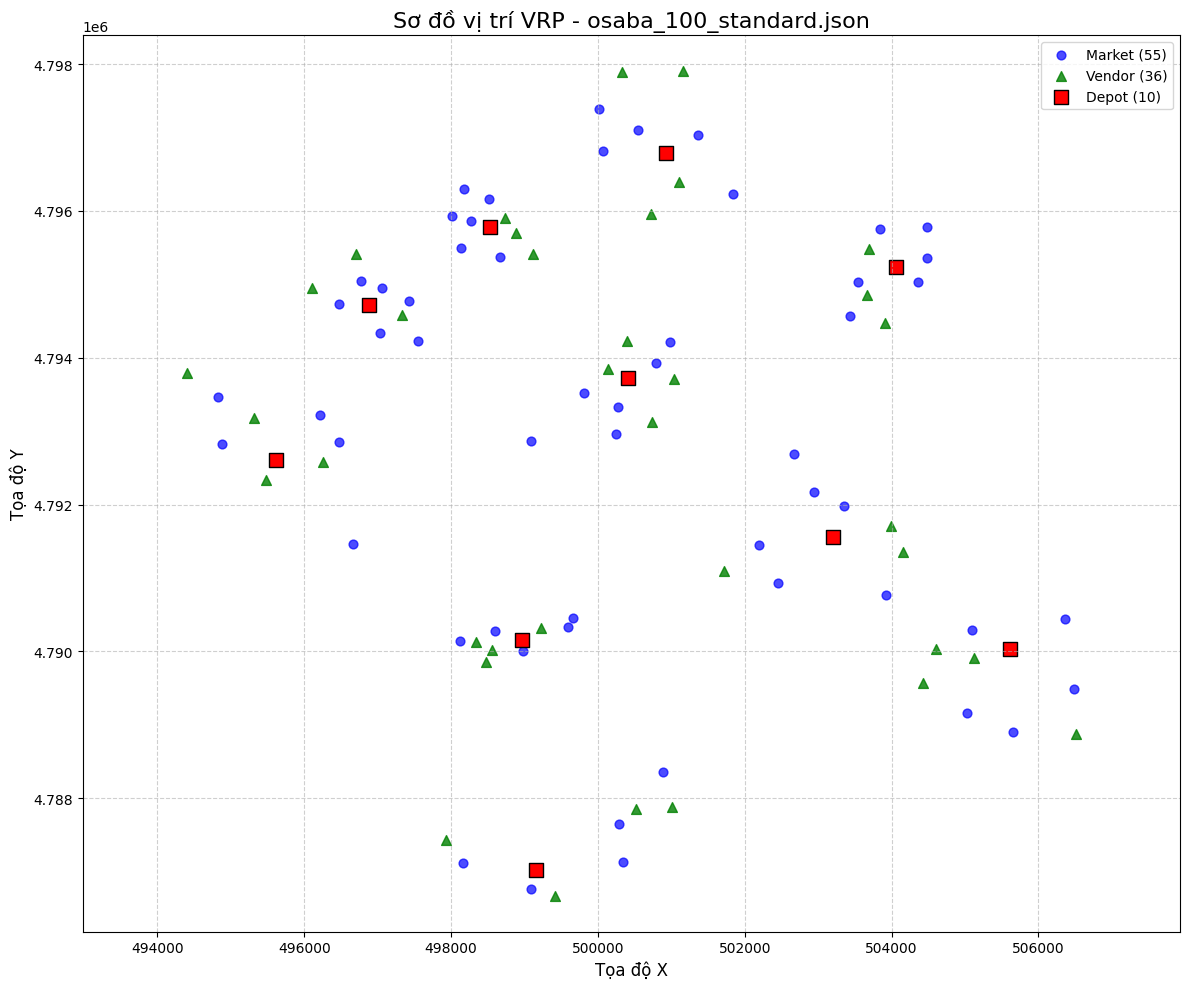

In [4]:
import json
import matplotlib.pyplot as plt
import os

def plot_vrp_nodes(json_path):
    """
    Đọc tệp JSON VRP4 (đã chuẩn hóa) và vẽ sơ đồ 
    vị trí các depot, vendor, và market.
    """
    
    # --- 1. Đọc tệp JSON ---
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"LỖI: Không tìm thấy tệp tin tại: {json_path}")
        print("Hãy đảm bảo đường dẫn chính xác.")
        return
    except json.JSONDecodeError:
        print(f"LỖI: Không thể đọc tệp JSON (có thể tệp bị lỗi): {json_path}")
        return
    
    if 'nodes' not in data:
        print("LỖI: Tệp JSON không có key 'nodes'. Định dạng không hợp lệ.")
        return
        
    nodes = data['nodes']
    
    # --- 2. Phân loại tọa độ ---
    # Tạo các dictionary để lưu tọa độ (x, y) cho từng loại
    locations = {
        "depot": {"x": [], "y": []},
        "vendor": {"x": [], "y": []},
        "market": {"x": [], "y": []}
    }
    
    for node in nodes:
        node_type = node.get('type')
        x = node.get('coord_x')
        y = node.get('coord_y')
        
        # Thêm tọa độ vào danh sách tương ứng
        if node_type in locations and x is not None and y is not None:
            locations[node_type]["x"].append(x)
            locations[node_type]["y"].append(y)
        else:
            # In cảnh báo nếu có node không rõ loại hoặc thiếu tọa độ
            print(f"Cảnh báo: Bỏ qua node {node.get('id')} do thiếu 'type' hoặc 'coord'.")
            
    n_depots = len(locations["depot"]["x"])
    n_vendors = len(locations["vendor"]["x"])
    n_markets = len(locations["market"]["x"])
    
    print(f"Đã tải {len(nodes)} node:")
    print(f"  - {n_depots} Depots (Kho)")
    print(f"  - {n_vendors} Vendors (Nhà cung cấp)")
    print(f"  - {n_markets} Markets (Khách hàng)")

    # --- 3. Vẽ biểu đồ ---
    plt.figure(figsize=(12, 10))
    
    # Vẽ Markets (nền)
    plt.scatter(locations["market"]["x"], locations["market"]["y"],
                marker='o', # o = hình tròn
                color='blue', 
                s=40,        # s = kích thước
                alpha=0.7,   # alpha = độ trong suốt
                label=f'Market ({n_markets})')
    
    # Vẽ Vendors
    plt.scatter(locations["vendor"]["x"], locations["vendor"]["y"],
                marker='^', # ^ = hình tam giác
                color='green', 
                s=50, 
                alpha=0.8,
                label=f'Vendor ({n_vendors})')
    
    # Vẽ Depots (vẽ cuối cùng để nó nổi bật nhất)
    plt.scatter(locations["depot"]["x"], locations["depot"]["y"],
                marker='s', # s = hình vuông (square)
                color='red', 
                s=100,       # Kích thước lớn hơn
                edgecolor='black', # Thêm viền đen
                label=f'Depot ({n_depots})')
    
    # --- 4. Tinh chỉnh biểu đồ ---
    plt.title(f'Sơ đồ vị trí VRP - {os.path.basename(json_path)}', fontsize=16)
    plt.xlabel('Tọa độ X', fontsize=12)
    plt.ylabel('Tọa độ Y', fontsize=12)
    plt.legend(fontsize=10) # Hiển thị chú thích
    plt.grid(True, linestyle='--', alpha=0.6) # Thêm lưới mờ
    
    # Rất quan trọng: Đảm bảo tỉ lệ 2 trục bằng nhau
    # Nếu không, khoảng cách sẽ bị méo
    plt.axis('equal') 
    
    plt.tight_layout() # Tự động căn chỉnh
    
    # Hiển thị biểu đồ
    print("\nĐang hiển thị biểu đồ...")
    print("Tắt cửa sổ biểu đồ để kết thúc script.")
    plt.show()

# ==================================================================
# PHẦN THỰC THI CHÍNH
# ==================================================================
if __name__ == "__main__":
    # Đường dẫn TỆP VÀO (file JSON bạn đã tạo ở bước trước)
    input_json_path = r"C:\Users\thaip\Desktop\VRP4\data\JSON\osaba-100-instances\osaba_100_standard.json"
    
    # Kiểm tra xem tệp có tồn tại không trước khi chạy
    if not os.path.exists(input_json_path):
        print(f"LỖI: Không tìm thấy tệp đầu vào tại đường dẫn sau:")
        print(input_json_path)
        print("Vui lòng kiểm tra lại đường dẫn tệp 'osaba_100_standard.json'.")
    else:
        plot_vrp_nodes(input_json_path)

In [10]:
import json
import random
import os
from pathlib import Path # Sử dụng Pathlib cho đường dẫn

def generate_vehicle_data_from_nodes(
    path_nodes_json,
    path_json_out="osaba_100_vehicles",
    vehicles_per_depot=None,
    vehicle_types=None,
    capacity_scales=None,
    vehicle_costs=None,
    ratio_to_vendor=0.5,
    seed=42,
    equal_per_commodity=True
):
    random.seed(seed)

    # --- 1. Đọc dữ liệu node ---
    try:
        with open(path_nodes_json, "r", encoding="utf-8") as f:
            node_data = json.load(f)
    except FileNotFoundError:
        print(f"LỖI: Không tìm thấy tệp node tại: {path_nodes_json}")
        return
    except json.JSONDecodeError:
         print(f"LỖI: Tệp JSON node không hợp lệ: {path_nodes_json}")
         return


    if "meta" not in node_data or "nodes" not in node_data:
        print(f"LỖI: Tệp {path_nodes_json} có vẻ không đúng định dạng.")
        return

    meta = node_data["meta"]
    
    # Lấy thông tin depot và commodities từ meta hoặc nodes
    try:
        commodities = meta["commodities"]
        # Đếm số depot thực tế từ list nodes thay vì chỉ dựa vào meta["n_depots"]
        actual_depots = [n for n in node_data["nodes"] if n.get("type") == "depot"]
        n_depots = len(actual_depots)
        if n_depots == 0:
             print("LỖI: Không tìm thấy node depot nào trong file.")
             return
    except KeyError:
        print("LỖI: Thiếu thông tin 'commodities' hoặc 'nodes' trong file JSON.")
        return
        
    K = len(commodities) 

    # --- 2. Tính tổng cung từ vendor ---
    total_vendor = {c: 0.0 for c in commodities}
    vendor_count = 0
    for n in node_data["nodes"]:
        if n.get("type") == "vendor":
            vendor_count += 1
            goods_dict = n.get("collected_goods_dict", {})
            for c in commodities:
                total_vendor[c] += float(goods_dict.get(c, 0.0))

    if vendor_count == 0:
        print("CẢNH BÁO: Không tìm thấy 'vendor' nào.")

    # --- 3. Tham số mặc định ---
    if vehicle_types is None:
        vehicle_types = ["type_1", "type_2", "type_3"]
    if capacity_scales is None:
        capacity_scales = {"type_1": 1.0, "type_2": 1.5, "type_3": 2.3}
    if vehicle_costs is None:
        vehicle_costs = {"type_1": 1.0, "type_2": 1.3, "type_3": 1.8}
    if vehicles_per_depot is None:
        # Mặc định: mỗi depot có số xe bằng số loại xe
        vehicles_per_depot = [len(vehicle_types)] * n_depots
        print(f"vehicles_per_depot không được cung cấp, mặc định là: {vehicles_per_depot}")


    if len(vehicles_per_depot) != n_depots:
         print(f"⚠️ Lỗi: Độ dài 'vehicles_per_depot' ({len(vehicles_per_depot)}) "
               f"khác với số depot tìm thấy ({n_depots})")
         # Cố gắng sửa lỗi bằng cách lặp lại hoặc cắt bớt
         if len(vehicles_per_depot) > n_depots:
              vehicles_per_depot = vehicles_per_depot[:n_depots]
         elif len(vehicles_per_depot) > 0: # Ít hơn n_depots nhưng > 0
              vehicles_per_depot = (vehicles_per_depot * (n_depots // len(vehicles_per_depot) + 1))[:n_depots]
         else: # List rỗng
              vehicles_per_depot = [len(vehicle_types)] * n_depots # Quay về mặc định
         print(f"Đã tự động điều chỉnh vehicles_per_depot thành: {vehicles_per_depot}")


    total_vehicle = sum(vehicles_per_depot)
    if total_vehicle == 0:
        print("CẢNH BÁO: Tổng số xe là 0.")
        
    # --- 4. Chuẩn bị tạo danh sách xe (để biết tổng scale) ---
    type_choices = []
    
    # (*** LOGIC MỚI ***)
    # Kiểm tra điều kiện đặc biệt: 3 loại xe và mỗi depot có 3 xe
    is_special_case = (len(vehicle_types) == 3 and all(n == 3 for n in vehicles_per_depot))

    if is_special_case:
        print("Áp dụng logic gán đặc biệt: Mỗi depot nhận 1 xe mỗi loại.")
        shuffled_types = vehicle_types[:] # Tạo bản sao
        for depot_id, n_vehicle in enumerate(vehicles_per_depot):
             # n_vehicle chắc chắn là 3 ở đây
             random.shuffle(shuffled_types) # Xáo trộn thứ tự loại xe cho mỗi depot
             type_choices.extend(shuffled_types)
    else:
        print("Áp dụng logic gán ngẫu nhiên loại xe.")
        # Logic cũ: Gán loại xe ngẫu nhiên cho từng slot xe
        for depot_id, n_vehicle in enumerate(vehicles_per_depot):
            for _ in range(n_vehicle):
                if not vehicle_types: # Xử lý trường hợp list rỗng
                     print("Lỗi: vehicle_types rỗng!")
                     return
                type_choices.append(random.choice(vehicle_types))
                
    # Đảm bảo số lượng type_choices khớp tổng số xe
    if len(type_choices) != total_vehicle:
        print(f"Lỗi logic: Số lượng type_choices ({len(type_choices)}) không khớp total_vehicle ({total_vehicle})")
        # Fallback về random nếu có lỗi
        type_choices = [random.choice(vehicle_types) for _ in range(total_vehicle)] if vehicle_types else []


    scales_list = [capacity_scales.get(t, 1.0) for t in type_choices]
    sum_scales = sum(scales_list)
    scale_mean = sum_scales / total_vehicle if total_vehicle > 0 else 1.0

    # --- 5. Mục tiêu capacity ---
    total_vendor_all = sum(total_vendor.values())
    target_total_capacity_all = ratio_to_vendor * total_vendor_all

    vehicles = []
    v_global_idx = 0 # ID xe toàn cục

    if total_vehicle > 0: # Chỉ tạo xe nếu có
        if equal_per_commodity:
            if K == 0 or sum_scales == 0:
                base_scalar = 0.0
            else:
                base_scalar = target_total_capacity_all / (K * sum_scales)

            depot_idx_counter = 0
            vehicles_assigned_to_depot = 0
            for i in range(total_vehicle):
                type_name = type_choices[i]
                scale = capacity_scales.get(type_name, 1.0) # Lấy scale đúng
                per_commodity_cap = round(base_scalar * scale, 1)
                cap_dict = {c: per_commodity_cap for c in commodities}
                cap_vec = [per_commodity_cap] * K
                
                vehicles.append({
                    "vehicle_id": f"D{depot_idx_counter}_V{v_global_idx}",
                    "depot_id": depot_idx_counter,
                    "vehicle_type": type_name,
                    "capacity_dict": cap_dict,
                    "capacity_vec": cap_vec,
                    "total_capacity": round(per_commodity_cap * K, 1),
                    "cost_per_km": vehicle_costs.get(type_name, 1.0)
                })
                v_global_idx += 1
                vehicles_assigned_to_depot += 1
                # Chuyển sang depot tiếp theo nếu đã đủ xe cho depot hiện tại
                if vehicles_assigned_to_depot >= vehicles_per_depot[depot_idx_counter]:
                    depot_idx_counter += 1
                    vehicles_assigned_to_depot = 0
                
        else: # Logic capacity theo tỉ lệ cung vendor
            target_capacity = {c: total_vendor[c] * ratio_to_vendor for c in commodities}
            base_capacity = {
                c: (target_capacity[c] / sum_scales) if sum_scales > 0 else 0.0
                for c in commodities
            }
            
            depot_idx_counter = 0
            vehicles_assigned_to_depot = 0
            for i in range(total_vehicle):
                type_name = type_choices[i]
                scale = capacity_scales.get(type_name, 1.0) # Lấy scale đúng
                cap_dict = {c: round(base_capacity[c] * scale, 1) for c in commodities}
                cap_vec = [cap_dict.get(c, 0.0) for c in commodities] # Đảm bảo đúng thứ tự

                vehicles.append({
                    "vehicle_id": f"D{depot_idx_counter}_V{v_global_idx}",
                    "depot_id": depot_idx_counter,
                    "vehicle_type": type_name,
                    "capacity_dict": cap_dict,
                    "capacity_vec": cap_vec,
                    "total_capacity": round(sum(cap_vec), 1),
                    "cost_per_km": vehicle_costs.get(type_name, 1.0)
                })
                v_global_idx += 1
                vehicles_assigned_to_depot += 1
                if vehicles_assigned_to_depot >= vehicles_per_depot[depot_idx_counter]:
                    depot_idx_counter += 1
                    vehicles_assigned_to_depot = 0

    data = {
        "meta": {
            "n_depots": n_depots,
            "n_vehicles": len(vehicles),
            "vehicle_types_defined": vehicle_types,
            "vehicle_costs": vehicle_costs,
            "capacity_scales": capacity_scales,
            "ratio_to_vendor_target": ratio_to_vendor,
            "capacity_mode": "equal_per_commodity" if equal_per_commodity else "proportional_by_vendor"
        },
        "vehicles": vehicles
    }
    
    # Tạo thư mục nếu chưa tồn tại
    output_path = Path(path_json_out) # Chuyển sang Pathlib
    output_path.parent.mkdir(parents=True, exist_ok=True)

    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2)

    # --- 6. Thống kê ---
    if not commodities:
        print(f"✅ Vehicle JSON (không có hàng hóa) saved to {output_path}")
        return

    total_cap = {c: sum(v["capacity_dict"].get(c, 0.0) for v in vehicles) for c in commodities}
    total_vendor_all_safe = sum(total_vendor.values()) if sum(total_vendor.values()) > 0 else 1.0 # Tránh chia cho 0
    
    ratio_real_by_c = {
        k: (total_cap[k] / total_vendor[k] * 100) if total_vendor.get(k, 0.0) > 0 else 0.0
        for k in commodities
    }
    ratio_real_total = (sum(total_cap.values()) / total_vendor_all_safe * 100)

    print(f"✅ Vehicle JSON saved to {output_path}")
    print(f"📦 Tổng xe mỗi depot: {vehicles_per_depot} (Tổng: {total_vehicle} xe)")
    print("📦 Tổng cung vendor:", {k: round(v, 1) for k, v in total_vendor.items()})
    print("🚚 Tổng capacity xe:", {k: round(v, 1) for k, v in total_cap.items()})
    print(f"🎯 Mục tiêu tỷ lệ capacity: {ratio_to_vendor * 100:.1f}%")
    print(f"📊 Tỷ lệ capacity thực tế (tổng): {ratio_real_total:.1f}%")
    print(f"⚙️ Chế độ capacity: {'Bằng nhau mỗi loại' if equal_per_commodity else 'Tỷ lệ theo cung'}")


# ==================================================================
# PHẦN THỰC THI CHÍNH
# ==================================================================
if __name__ == "__main__":
    
    # --- Đường dẫn cho file 100 instances ---
    BASE_DIR_100 = Path(r"C:\Users\thaip\Desktop\VRP4\data\JSON\osaba-100-instances")
    
    path_nodes_json_100 = BASE_DIR_100 / "osaba_100_standard.json"
    path_json_out_100 = BASE_DIR_100 / "osaba_100_vehicles.json" # Sửa tên file output

    # --- Cấu hình đội xe ---
    
    # File 100 instances có 10 depot (kiểm tra lại file node nếu không chắc)
    # Gán 3 xe cho mỗi depot
    n_depots_100 = 10 # Cần xác nhận số depot này từ file node
    n_xe_moi_depot_100 = [3] * n_depots_100 # Tạo list có 10 số 3
    
    # Sử dụng 3 loại xe
    cac_loai_xe_100 = ["small_truck", "medium_truck", "large_truck"]
    ty_le_capacity_100 = {
        "small_truck": 1.0,
        "medium_truck": 1.8,
        "large_truck": 2.5
    }
    chi_phi_xe_100 = {
        "small_truck": 1.0,
        "medium_truck": 1.5,
        "large_truck": 2.2
    }
    
    print(f"--- BẮT ĐẦU TẠO ĐỘI XE CHO FILE: {path_nodes_json_100.name} ---")
    
    if not path_nodes_json_100.exists():
        print(f"LỖI: Không tìm thấy tệp đầu vào tại:")
        print(path_nodes_json_100)
    else:
        generate_vehicle_data_from_nodes(
            path_nodes_json=str(path_nodes_json_100), # Chuyển Path thành string
            path_json_out=str(path_json_out_100), # Chuyển Path thành string
            
            vehicles_per_depot=n_xe_moi_depot_100,
            vehicle_types=cac_loai_xe_100,
            capacity_scales=ty_le_capacity_100,
            vehicle_costs=chi_phi_xe_100,
            
            ratio_to_vendor=0.8,
            equal_per_commodity=True,
            seed=42
        )
        
        print("\n🎉 HOÀN THÀNH.")

--- BẮT ĐẦU TẠO ĐỘI XE CHO FILE: osaba_100_standard.json ---
Áp dụng logic gán đặc biệt: Mỗi depot nhận 1 xe mỗi loại.
✅ Vehicle JSON saved to C:\Users\thaip\Desktop\VRP4\data\JSON\osaba-100-instances\osaba_100_vehicles.json
📦 Tổng xe mỗi depot: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3] (Tổng: 30 xe)
📦 Tổng cung vendor: {'food': 1372.5, 'drink': 1357.5, 'electronics': 1330.5, 'household': 1354.0}
🚚 Tổng capacity xe: {'food': 1083.0, 'drink': 1083.0, 'electronics': 1083.0, 'household': 1083.0}
🎯 Mục tiêu tỷ lệ capacity: 80.0%
📊 Tỷ lệ capacity thực tế (tổng): 80.0%
⚙️ Chế độ capacity: Bằng nhau mỗi loại

🎉 HOÀN THÀNH.



🔄 Bắt đầu phân cụm hybrid (load-balanced + distance) cho 36 vendors...

✅ Phân cụm hoàn tất. Tổng kết tải mỗi depot:
- Depot 6: Bottleneck 100.0% | Chi tiết: ['59.9%', '81.9%', '100.0%', '80.9%']
- Depot 15: Bottleneck 92.1% | Chi tiết: ['92.1%', '82.2%', '81.7%', '56.4%']
- Depot 26: Bottleneck 81.5% | Chi tiết: ['49.3%', '55.0%', '81.5%', '51.8%']
- Depot 38: Bottleneck 80.7% | Chi tiết: ['66.0%', '68.5%', '42.9%', '80.7%']
- Depot 45: Bottleneck 80.8% | Chi tiết: ['61.0%', '71.7%', '80.8%', '73.4%']
- Depot 56: Bottleneck 97.7% | Chi tiết: ['80.7%', '56.9%', '72.9%', '97.7%']
- Depot 66: Bottleneck 92.5% | Chi tiết: ['78.3%', '92.5%', '67.4%', '72.0%']
- Depot 74: Bottleneck 100.0% | Chi tiết: ['98.5%', '100.0%', '83.7%', '90.4%']
- Depot 85: Bottleneck 76.4% | Chi tiết: ['76.4%', '50.9%', '52.8%', '56.9%']
- Depot 94: Bottleneck 72.2% | Chi tiết: ['68.7%', '72.2%', '68.5%', '70.4%']

💾 Đang lưu kết quả phân cụm vào: C:\\Users\\thaip\\Desktop\\VRP4\\data\\JSON\\osaba-100-instances\

C:\Users\thaip\AppData\Local\Temp\ipykernel_17924\2755822179.py:119: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10' if n_depots <= 10 else 'tab20', n_depots)


💾 Biểu đồ đã được lưu vào: C:\\Users\\thaip\\Desktop\\VRP4\\data\\JSON\\osaba-100-instances\osaba_100_standard_cluster_plot.png

Hiển thị biểu đồ...


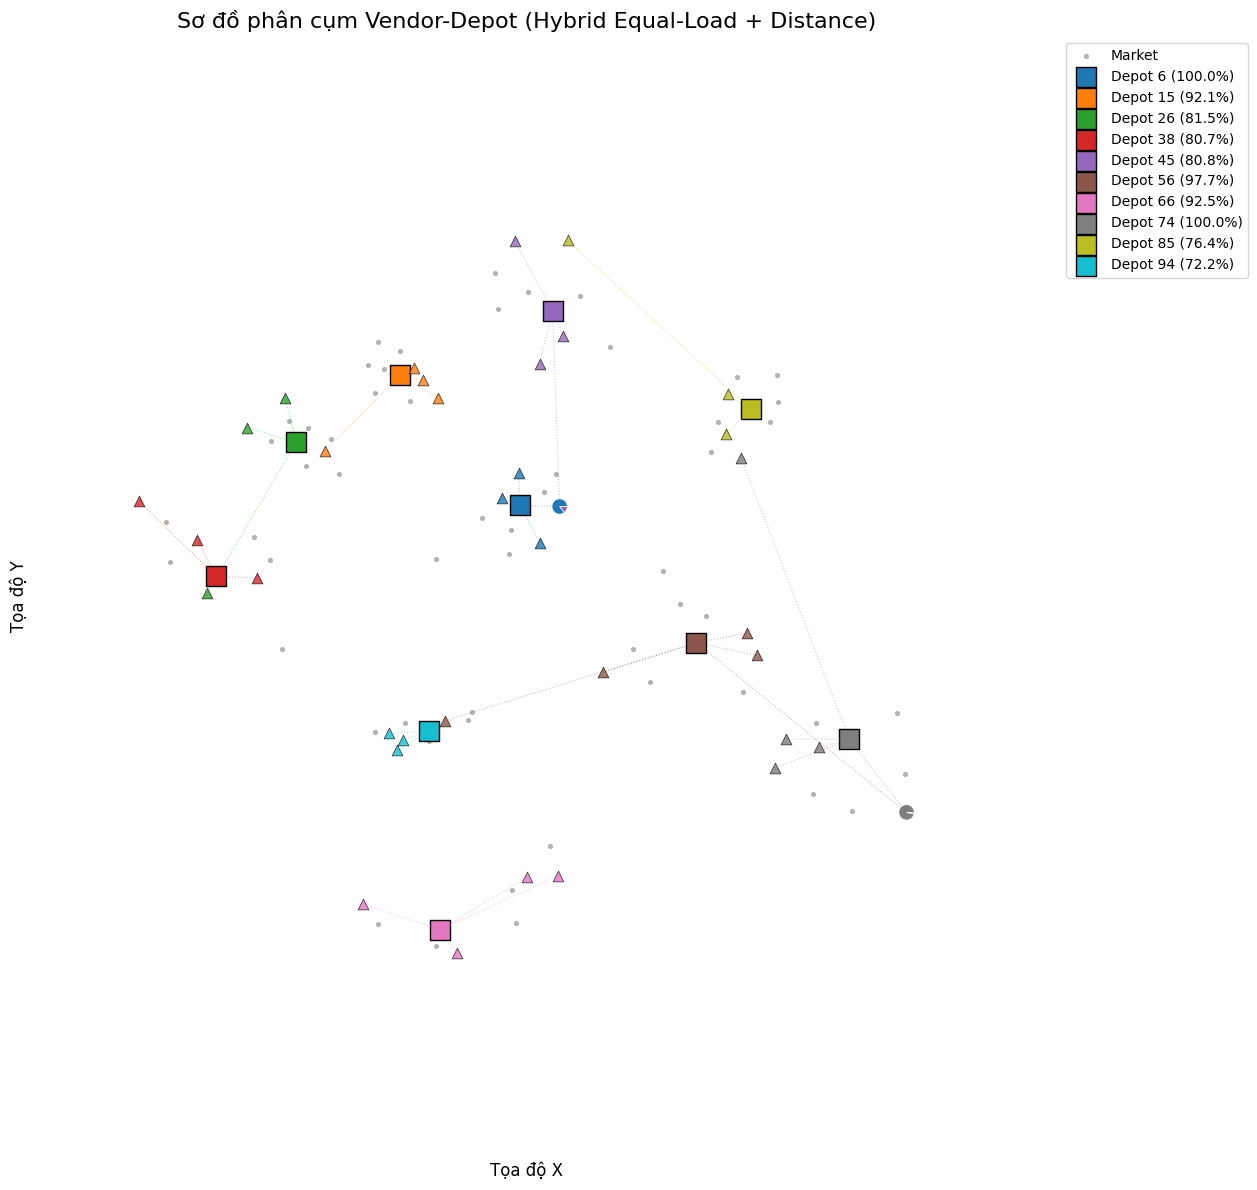

In [3]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def calculate_distance(node1, node2):
    return abs(node1['coord_x'] - node2['coord_x']) + abs(node1['coord_y'] - node2['coord_y'])

def assign_vendors_to_depots(data):
    THRESHOLD_LOAD = 0.70  # 70%

    commodities = data['meta']['commodities']
    K = len(commodities)

    depots = [n for n in data['nodes'] if n['type'] == 'depot']
    vendors = [n for n in data['nodes'] if n['type'] == 'vendor']

    if not depots:
        print("LỖI: Không tìm thấy depot nào trong tệp JSON.")
        return {}, [], {}, {}

    depot_remaining_capacity = {
        d['id']: np.array(d['storage_capacity_vec']) for d in depots
    }
    depot_initial_capacity = {
        d['id']: np.array(d['storage_capacity_vec']) for d in depots
    }
    total_demand_assigned = {
        d['id']: np.zeros(K) for d in depots
    }

    vendor_assignments = {}
    unassigned_vendors_log = []

    vendors.sort(key=lambda v: sum(v['collected_goods_vec']), reverse=True)
    print(f"\n🔄 Bắt đầu phân cụm hybrid (load-balanced + distance) cho {len(vendors)} vendors...")

    for vendor in vendors:
        vendor_id = vendor['id']
        remaining_demand_vec = np.array(vendor['collected_goods_vec'])
        assignments = []

        def depot_load_ratio(d_id):
            assigned = total_demand_assigned[d_id]
            capacity = depot_initial_capacity[d_id]
            return np.max(np.divide(
                assigned, capacity, out=np.zeros_like(assigned), where=capacity != 0
            ))

        eligible_depots = [
            d for d in depots if depot_load_ratio(d['id']) < THRESHOLD_LOAD
        ]

        if not eligible_depots:
            eligible_depots = depots

        sorted_depots = sorted(
            eligible_depots,
            key=lambda d: calculate_distance(vendor, d)
        )

        for depot in sorted_depots:
            d_id = depot['id']
            cap_vec = depot_remaining_capacity[d_id]
            assign_vec = np.minimum(remaining_demand_vec, cap_vec)

            if np.any(assign_vec > 1e-5):
                assignments.append({
                    'depot_id': d_id,
                    'assigned_vec': assign_vec
                })
                depot_remaining_capacity[d_id] -= assign_vec
                total_demand_assigned[d_id] += assign_vec
                remaining_demand_vec -= assign_vec

            if np.all(remaining_demand_vec <= 1e-5):
                break

        vendor_assignments[vendor_id] = assignments

        if np.any(remaining_demand_vec > 1e-5):
            unassigned_vendors_log.append({
                'id': vendor_id,
                'remaining_demand_vec': remaining_demand_vec
            })

    print("\n✅ Phân cụm hoàn tất. Tổng kết tải mỗi depot:")
    depot_stats = {}
    for d in depots:
        d_id = d['id']
        init = depot_initial_capacity[d_id]
        used = total_demand_assigned[d_id]
        fill_pct = np.divide(used, init, out=np.zeros_like(used), where=init != 0) * 100
        max_fill = np.max(fill_pct)
        depot_stats[d_id] = {
            'fill_percent_vec': fill_pct.tolist(),
            'fill_percent': max_fill
        }
        print(f"- Depot {d_id}: Bottleneck {max_fill:.1f}% | Chi tiết: {[f'{v:.1f}%' for v in fill_pct]}")

    vendor_color_map = {
        v_id: assigns[0]['depot_id'] if assigns else -1
        for v_id, assigns in vendor_assignments.items()
    }

    return vendor_assignments, unassigned_vendors_log, depot_stats, vendor_color_map

def plot_clustered_nodes(json_path, vendor_assignments, unassigned_vendors_log, depot_stats, vendor_color_map, output_image_path=None):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    depots = [n for n in data['nodes'] if n['type'] == 'depot']
    vendors = [n for n in data['nodes'] if n['type'] == 'vendor']
    markets = [n for n in data['nodes'] if n['type'] == 'market']

    depot_ids = [d['id'] for d in depots]
    n_depots = len(depot_ids)
    cmap = plt.cm.get_cmap('tab10' if n_depots <= 10 else 'tab20', n_depots)
    depot_color_map = {depot_id: cmap(i) for i, depot_id in enumerate(depot_ids)}

    fig, ax = plt.subplots(figsize=(15, 12))
    all_x = [n['coord_x'] for n in depots + vendors + markets]
    all_y = [n['coord_y'] for n in depots + vendors + markets]
    pie_radius = max(np.ptp(all_x), np.ptp(all_y)) * 0.01

    ax.scatter([m['coord_x'] for m in markets], [m['coord_y'] for m in markets], marker='.', color='gray', s=30, alpha=0.5, label='Market')

    for depot in depots:
        depot_id = depot['id']
        color = depot_color_map[depot_id]
        stats = depot_stats.get(depot_id, {"fill_percent": 0.0})
        ax.scatter(depot['coord_x'], depot['coord_y'], marker='s', color=color, s=200, edgecolor='black', label=f"Depot {depot_id} ({stats['fill_percent']:.1f}%)")

    for v_node in vendors:
        v_id = v_node['id']
        assignments_list = vendor_assignments.get(v_id)
        if not assignments_list:
            continue

        for assignment in assignments_list:
            d_id = assignment['depot_id']
            depot_node = next((d for d in depots if d['id'] == d_id), None)
            if not depot_node: continue
            color = depot_color_map[d_id]
            ax.plot([v_node['coord_x'], depot_node['coord_x']], [v_node['coord_y'], depot_node['coord_y']], color=color, linestyle=':', alpha=0.4, linewidth=0.8)

        if len(assignments_list) == 1:
            color = depot_color_map[assignments_list[0]['depot_id']]
            ax.scatter(v_node['coord_x'], v_node['coord_y'], marker='^', color=color, s=60, alpha=0.8, edgecolor='black', linewidth=0.5)
        elif len(assignments_list) > 1:
            pie_data, pie_colors = [], []
            total_demand = np.sum(v_node['collected_goods_vec'])
            for assign in assignments_list:
                pie_data.append(np.sum(assign['assigned_vec']) / total_demand)
                pie_colors.append(depot_color_map[assign['depot_id']])
            ax.pie(pie_data, colors=pie_colors, center=(v_node['coord_x'], v_node['coord_y']), radius=pie_radius, wedgeprops={'edgecolor': 'white', 'linewidth': 0.5}, normalize=True)

    if unassigned_vendors_log:
        unassigned_ids = [log['id'] for log in unassigned_vendors_log]
        nodes = [v for v in vendors if v['id'] in unassigned_ids]
        ax.scatter([v['coord_x'] for v in nodes], [v['coord_y'] for v in nodes], marker='X', color='black', s=80, alpha=0.9, label=f'Unassigned ({len(nodes)})')

    ax.set_title('Sơ đồ phân cụm Vendor-Depot (Hybrid Equal-Load + Distance)', fontsize=16)
    ax.set_xlabel('Tọa độ X', fontsize=12)
    ax.set_ylabel('Tọa độ Y', fontsize=12)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.axis('equal')
    fig.tight_layout(rect=[0, 0, 0.85, 1])

    if output_image_path:
        try:
            fig.savefig(output_image_path, bbox_inches='tight', dpi=150)
            print(f"💾 Biểu đồ đã được lưu vào: {output_image_path}")
        except Exception as e:
            print(f"LỖI: Không thể lưu biểu đồ: {e}")

    print("\nHiển thị biểu đồ...")
    plt.show()

if __name__ == "__main__":
    input_json_path = r"C:\\Users\\thaip\\Desktop\\VRP4\\data\\JSON\\osaba-100-instances\\osaba_100_standard.json"

    if not os.path.exists(input_json_path):
        print(f"LỖI: Không tìm thấy tệp đầu vào tại: {input_json_path}")
    else:
        with open(input_json_path, 'r', encoding='utf-8') as f:
            vrp_data = json.load(f)

        assignments, unassigned_logs, stats, color_map = assign_vendors_to_depots(vrp_data)

        out_dir = os.path.dirname(input_json_path)
        out_base = os.path.basename(input_json_path).replace('.json', '')

        output_assignment_path = os.path.join(out_dir, f"{out_base}_assignments.json")
        output_image_path = os.path.join(out_dir, f"{out_base}_cluster_plot.png")

        print(f"\n💾 Đang lưu kết quả phân cụm vào: {output_assignment_path}")
        try:
            assignments_serializable = {
                v_id: [{
                    'depot_id': a['depot_id'],
                    'assigned_vec': a['assigned_vec'].tolist()
                } for a in assigns] for v_id, assigns in assignments.items()
            }
            unassigned_serializable = [{
                'id': log['id'],
                'remaining_demand_vec': log['remaining_demand_vec'].tolist()
            } for log in unassigned_logs]

            output_data = {
                "vendor_assignments": assignments_serializable,
                "depot_stats": stats,
                "unassigned_vendors_log": unassigned_serializable
            }
            with open(output_assignment_path, 'w', encoding='utf-8') as f:
                json.dump(output_data, f, indent=2)
            print("✅ Đã lưu file assignment JSON thành công.")
        except Exception as e:
            print(f"LỖI: Không thể lưu JSON: {e}")

        plot_clustered_nodes(input_json_path, assignments, unassigned_logs, stats, color_map, output_image_path)

In [7]:
import json
import os
import numpy as np

def calculate_distance(node1, node2):
    return abs(node1['coord_x'] - node2['coord_x']) + abs(node1['coord_y'] - node2['coord_y'])

def assign_vendors_to_depots(data):
    commodities = data['meta']['commodities']
    K = len(commodities)
    
    depots = []
    vendors = []
    for node in data['nodes']:
        if node['type'] == 'depot':
            depots.append(node)
        elif node['type'] == 'vendor':
            vendors.append(node)
            
    if not depots:
        print("LỖI: Không tìm thấy depot nào trong tệp JSON.")
        return {}, [], {}, {}, {}, {} 

    depot_remaining_capacity = {
        d['id']: np.array(d['storage_capacity_vec']) 
        for d in depots
    }
    depot_initial_capacity = {
        d['id']: np.array(d['storage_capacity_vec']) 
        for d in depots
    }
    
    vendor_assignments = {} 
    unassigned_vendors_log = []

    vendors.sort(
        key=lambda v: sum(v['collected_goods_vec']), 
        reverse=True
    )

    print(f"Bắt đầu phân cụm (cho phép tách) cho {len(vendors)} vendors vào {len(depots)} depots...")

    for vendor in vendors:
        vendor_id = vendor['id']
        vendor_demand_vec_total = np.array(vendor['collected_goods_vec'])
        remaining_demand_vec = vendor_demand_vec_total.copy()
        
        assignments_for_this_vendor = []
        
        depots_sorted_by_dist = sorted(
            depots, 
            key=lambda d: calculate_distance(vendor, d)
        )
        
        for depot in depots_sorted_by_dist:
            depot_id = depot['id']
            depot_cap_vec = depot_remaining_capacity[depot_id]
            
            assignable_vec = np.minimum(remaining_demand_vec, depot_cap_vec)
            
            if np.any(assignable_vec > 1e-5):
                assignments_for_this_vendor.append({
                    'depot_id': depot_id,
                    'assigned_vec': assignable_vec
                })
                
                depot_remaining_capacity[depot_id] -= assignable_vec
                
                remaining_demand_vec -= assignable_vec
                
            if np.all(remaining_demand_vec <= 1e-5):
                break
        
        vendor_assignments[vendor_id] = assignments_for_this_vendor
        
        if np.any(remaining_demand_vec > 1e-5):
            unassigned_vendors_log.append({
                'id': vendor_id,
                'remaining_demand_vec': remaining_demand_vec
            })

    n_fully_assigned = len(vendors) - len(unassigned_vendors_log)
    
    print("\n--- KẾT QUẢ PHÂN CỤM ---")
    print(f"✅ Gán thành công (toàn bộ): {n_fully_assigned} / {len(vendors)} vendors")
    if unassigned_vendors_log:
        print(f"⚠️ Gán không hết (còn dư): {len(unassigned_vendors_log)} vendors")
        for log in unassigned_vendors_log[:5]:
            print(f"   - ID {log['id']} còn dư {np.sum(log['remaining_demand_vec']):.1f} (vec: {log['remaining_demand_vec']})")
            
    depot_stats = {}
    total_demand_assigned = {d['id']: np.zeros(K) for d in depots}
    vendor_color_map = {}
    
    for v_id, assignments_list in vendor_assignments.items():
        if not assignments_list:
            continue
            
        max_demand_sum = -1
        primary_depot_id = assignments_list[0]['depot_id']
        
        for assignment in assignments_list:
            d_id = assignment['depot_id']
            assigned_vec = assignment['assigned_vec']
            
            total_demand_assigned[d_id] += assigned_vec
            
            current_demand_sum = np.sum(assigned_vec)
            if current_demand_sum > max_demand_sum:
                max_demand_sum = current_demand_sum
                primary_depot_id = d_id
                
        vendor_color_map[v_id] = primary_depot_id
        
    print("\n--- TÌNH TRẠNG SỨC CHỨA DEPOT ---")
    for d in depots:
        d_id = d['id']
        init_cap_vec = depot_initial_capacity[d_id]
        assigned_demand_vec = total_demand_assigned[d_id]
        
        fill_pct_vec = np.divide(
            assigned_demand_vec, 
            init_cap_vec, 
            out=np.zeros_like(assigned_demand_vec), 
            where=init_cap_vec!=0
        ) * 100
        
        bottleneck_pct = np.max(fill_pct_vec)
        
        depot_stats[d_id] = {
            "fill_percent_vec": fill_pct_vec.tolist(),
            "fill_percent": bottleneck_pct
        }
        print(f"  Depot {d_id}: "
              f"Đầy (Bottleneck) {bottleneck_pct:.1f}%")
        print(f"      Chi tiết %: {[f'{p:.1f}%' for p in fill_pct_vec]} ({commodities})")

    return (
        vendor_assignments, 
        unassigned_vendors_log, 
        depot_stats, 
        vendor_color_map,
        total_demand_assigned,
        depot_initial_capacity
    )

if __name__ == "__main__":
    
    input_json_path = r"C:\Users\thaip\Desktop\VRP4\data\JSON\osaba-100-instances\osaba_100_standard.json"
    
    if not os.path.exists(input_json_path):
        print(f"LỖI: Không tìm thấy tệp đầu vào tại:")
        print(input_json_path)
    else:
        input_dir = os.path.dirname(input_json_path)
        input_filename = os.path.basename(input_json_path).replace('.json', '')
        
        output_assignment_path = os.path.join(
            input_dir, 
            "vendor_cluster_100.json"
        )
        
        with open(input_json_path, 'r', encoding='utf-8') as f:
            vrp_data = json.load(f)
        
        (
            assignments, 
            unassigned_logs, 
            stats, 
            color_map, 
            total_assigned_by_depot,
            initial_cap_by_depot
        ) = assign_vendors_to_depots(vrp_data)
        
        print(f"\nĐang lưu kết quả phân cụm (format mới) vào: {output_assignment_path}")
        try:
            commodities = vrp_data['meta']['commodities']
            K = len(commodities)
            
            depots_by_id = {
                n['id']: n for n in vrp_data['nodes'] if n['type'] == 'depot'
            }
            
            vendors_by_primary_depot = {}
            for v_id, d_id in color_map.items():
                if d_id not in vendors_by_primary_depot:
                    vendors_by_primary_depot[d_id] = []
                vendors_by_primary_depot[d_id].append(v_id)

            output_data = {"clusters": []}
            
            all_depot_ids = sorted(depots_by_id.keys())
            
            for d_id in all_depot_ids:
                depot_node = depots_by_id[d_id]
                
                storage_cap_dict = depot_node['storage_capacity_dict']
                
                assigned_mass_vec = total_assigned_by_depot.get(d_id, np.zeros(K))
                assigned_mass_dict = {
                    comm: round(mass, 1) 
                    for comm, mass in zip(commodities, assigned_mass_vec)
                }
                
                assigned_vendor_list = sorted(
                    vendors_by_primary_depot.get(d_id, [])
                )
                
                cluster_obj = {
                    "depot_node_id": d_id,
                    "depot_storage_capacity": storage_cap_dict,
                    "current_assigned_mass": assigned_mass_dict,
                    "assigned_vendors": assigned_vendor_list
                }
                output_data["clusters"].append(cluster_obj)

            with open(output_assignment_path, 'w', encoding='utf-8') as f:
                json.dump(output_data, f, indent=2)
            print(f"✅ Đã lưu file assignment (format mới) thành công.")

        except Exception as e:
            print(f"LỖI: không thể lưu file assignment JSON (format mới): {e}")
            


Bắt đầu phân cụm (cho phép tách) cho 36 vendors vào 10 depots...

--- KẾT QUẢ PHÂN CỤM ---
✅ Gán thành công (toàn bộ): 36 / 36 vendors

--- TÌNH TRẠNG SỨC CHỨA DEPOT ---
  Depot 6: Đầy (Bottleneck) 100.0%
      Chi tiết %: ['59.9%', '81.9%', '100.0%', '80.9%'] (['food', 'drink', 'electronics', 'household'])
  Depot 15: Đầy (Bottleneck) 71.3%
      Chi tiết %: ['60.2%', '61.7%', '71.3%', '47.2%'] (['food', 'drink', 'electronics', 'household'])
  Depot 26: Đầy (Bottleneck) 71.3%
      Chi tiết %: ['52.2%', '60.9%', '71.3%', '48.6%'] (['food', 'drink', 'electronics', 'household'])
  Depot 38: Đầy (Bottleneck) 95.0%
      Chi tiết %: ['95.0%', '83.0%', '63.6%', '93.1%'] (['food', 'drink', 'electronics', 'household'])
  Depot 45: Đầy (Bottleneck) 92.7%
      Chi tiết %: ['87.6%', '92.7%', '89.0%', '89.3%'] (['food', 'drink', 'electronics', 'household'])
  Depot 56: Đầy (Bottleneck) 78.8%
      Chi tiết %: ['51.9%', '40.7%', '60.0%', '78.8%'] (['food', 'drink', 'electronics', 'household'])
 

Đã tìm thấy file VRP data: C:\Users\thaip\Desktop\VRP4\data\JSON\osaba-100-instances\osaba_100_standard.json
Đã tìm thấy file tồn kho vendor: C:\Users\thaip\Desktop\VRP4\data\JSON\osaba-100-instances\vendor_cluster_100.json

Bắt đầu GIAI ĐOẠN 2: Phân cụm (cho phép tách) cho Markets...
Bắt đầu phân cụm (cho phép tách) cho 55 markets vào 10 depots (dựa trên tồn kho)...

--- KẾT QUẢ PHÂN CỤM MARKET ---
✅ Gán thành công (toàn bộ): 55 / 55 markets

--- TÌNH TRẠNG TỒN KHO DEPOT (SAU KHI GIAO HÀNG MARKET) ---
  Depot 6: Kho còn lại 33.2 (Đã giao 563.0)
      Chi tiết đã giao % (Bottleneck 100.0%): ['100.0%', '100.0%', '81.7%', '100.0%'] (['food', 'drink', 'electronics', 'household'])
  Depot 15: Kho còn lại 0.0 (Đã giao 444.5)
      Chi tiết đã giao % (Bottleneck 100.0%): ['100.0%', '100.0%', '100.0%', '100.0%'] (['food', 'drink', 'electronics', 'household'])
  Depot 26: Kho còn lại 0.0 (Đã giao 430.5)
      Chi tiết đã giao % (Bottleneck 100.0%): ['100.0%', '100.0%', '100.0%', '100.0%'] (['f

C:\Users\thaip\AppData\Local\Temp\ipykernel_21212\1641326063.py:151: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_depots)


💾 Biểu đồ đã được lưu vào: C:\Users\thaip\Desktop\VRP4\data\JSON\osaba-100-instances\market_assignments_plot.png

Đang hiển thị biểu đồ phân cụm...
Tắt cửa sổ biểu đồ để kết thúc script.


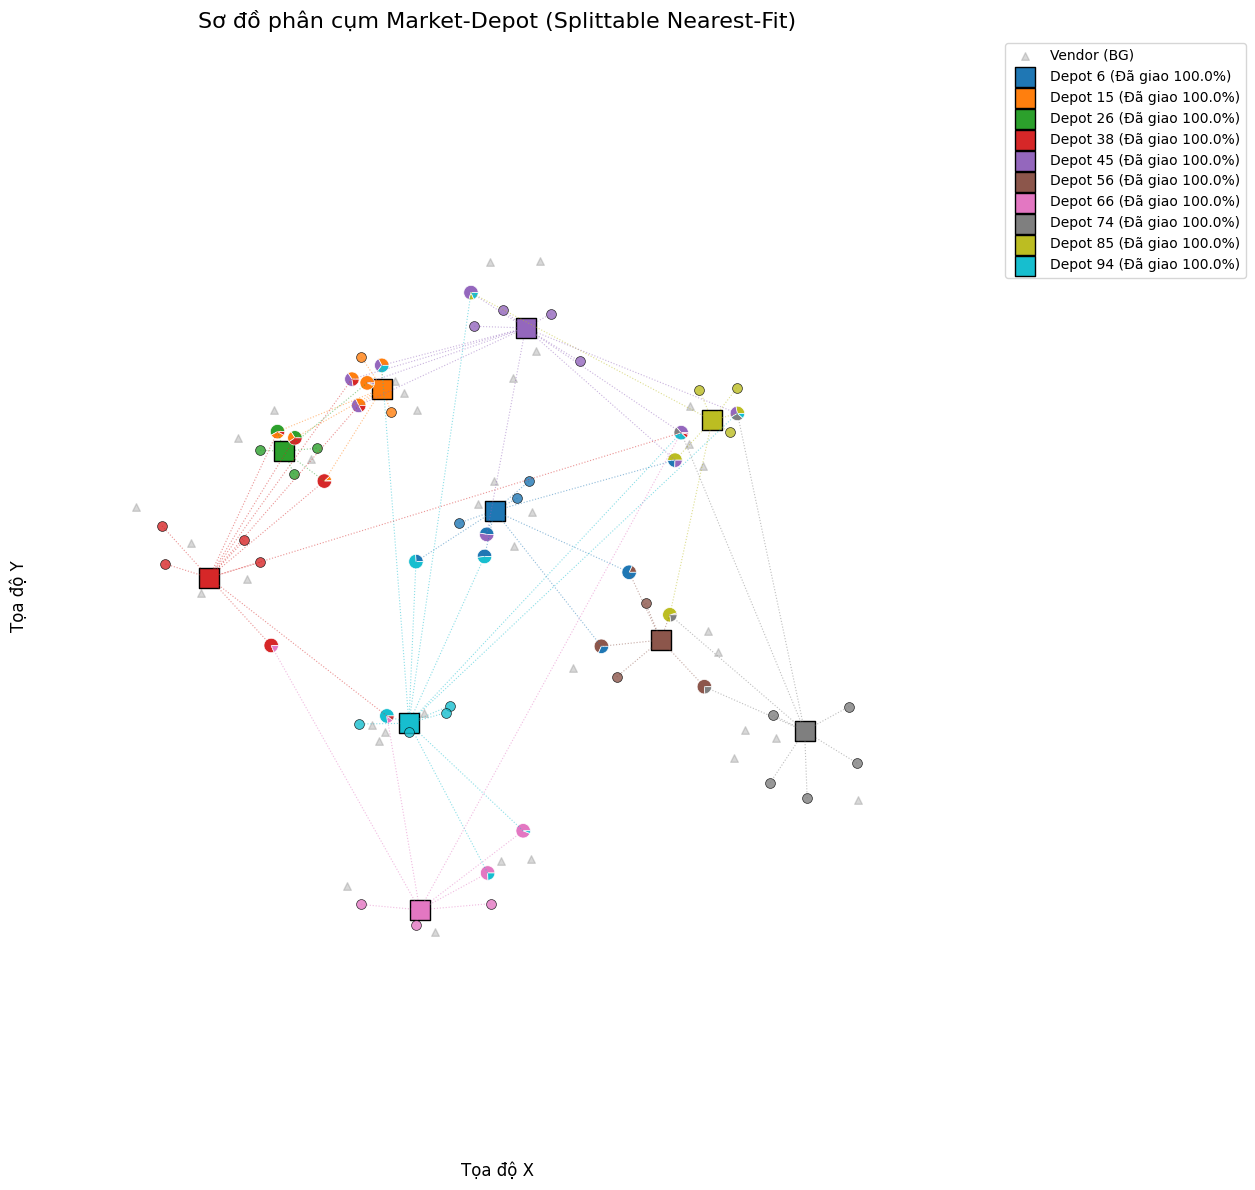


Đang lưu kết quả Giai đoạn 2 vào: C:\Users\thaip\Desktop\VRP4\data\JSON\osaba-100-instances\market_cluster_100.json
✅ Đã lưu file assignment market thành công.

Hoàn tất Giai đoạn 2.


In [9]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def calculate_distance(node1, node2):
    return abs(node1['coord_x'] - node2['coord_x']) + abs(node1['coord_y'] - node2['coord_y'])

def assign_markets_to_depots(vrp_data, vendor_cluster_data):
    print("\n" + "="*50)
    print(f"Bắt đầu GIAI ĐOẠN 2: Phân cụm (cho phép tách) cho Markets...")
    
    commodities = vrp_data['meta']['commodities']
    K = len(commodities)

    markets = []
    depots = []
    for node in vrp_data['nodes']:
        if node['type'] == 'market':
            markets.append(node)
        elif node['type'] == 'depot':
            depots.append(node)

    if not markets:
        print("LỖI: Không tìm thấy market nào trong tệp JSON.")
        return {}, [], {}
    if not depots:
         print("LỖI: Không tìm thấy depot nào trong tệp JSON (khi gán market).")
         return {}, [], {}

    depot_remaining_inventory = {}
    depot_initial_inventory = {} # (NEW) Thêm để tính %
    
    for cluster in vendor_cluster_data['clusters']:
        depot_id = cluster['depot_node_id']
        inventory_dict = cluster['current_assigned_mass']
        inventory_vec = np.array([inventory_dict.get(c, 0) for c in commodities])
        depot_remaining_inventory[depot_id] = inventory_vec
        depot_initial_inventory[depot_id] = inventory_vec.copy() # (NEW) Lưu tồn kho ban đầu
    
    all_depot_ids_in_vrp = {d['id'] for d in depots}
    for d_id in all_depot_ids_in_vrp:
         if d_id not in depot_remaining_inventory:
              depot_remaining_inventory[d_id] = np.zeros(K)
              depot_initial_inventory[d_id] = np.zeros(K) # (NEW)

    markets.sort(
        key=lambda m: sum(m['order_vec']), 
        reverse=True
    )

    print(f"Bắt đầu phân cụm (cho phép tách) cho {len(markets)} markets vào {len(depots)} depots (dựa trên tồn kho)...")

    market_assignments = {}
    unassigned_markets_log = []

    for market in markets:
        market_id = market['id']
        remaining_order_vec = np.array(market['order_vec'])
        assignments_for_this_market = []

        depots_sorted_by_dist = sorted(
            depots, 
            key=lambda d: calculate_distance(market, d)
        )

        for depot in depots_sorted_by_dist:
            depot_id = depot['id']
            depot_inv_vec = depot_remaining_inventory[depot_id]

            assignable_vec = np.minimum(remaining_order_vec, depot_inv_vec)

            if np.any(assignable_vec > 1e-5):
                assignments_for_this_market.append({
                    'depot_id': depot_id,
                    'assigned_vec': assignable_vec
                })
                depot_remaining_inventory[depot_id] -= assignable_vec
                remaining_order_vec -= assignable_vec

            if np.all(remaining_order_vec <= 1e-5):
                break
        
        market_assignments[market_id] = assignments_for_this_market

        if np.any(remaining_order_vec > 1e-5):
            unassigned_markets_log.append({
                'id': market_id,
                'remaining_demand_vec': remaining_order_vec
            })
    
    n_fully_assigned = len(markets) - len(unassigned_markets_log)
    print("\n--- KẾT QUẢ PHÂN CỤM MARKET ---")
    print(f"✅ Gán thành công (toàn bộ): {n_fully_assigned} / {len(markets)} markets")
    if unassigned_markets_log:
        print(f"⚠️ Gán không hết (còn dư): {len(unassigned_markets_log)} markets")
        for log in unassigned_markets_log[:5]:
            print(f"   - ID {log['id']} còn dư {np.sum(log['remaining_demand_vec']):.1f} (vec: {log['remaining_demand_vec']})")
    
    print("\n--- TÌNH TRẠNG TỒN KHO DEPOT (SAU KHI GIAO HÀNG MARKET) ---")
    depot_stats = {} # (NEW) Tạo depot_stats để vẽ biểu đồ
    for d in depots:
        d_id = d['id']
        final_inv_vec = depot_remaining_inventory.get(d_id, np.zeros(K))
        initial_inv_vec = depot_initial_inventory.get(d_id, np.zeros(K))
        
        delivered_vec = initial_inv_vec - final_inv_vec
        
        fill_pct_vec = np.divide(
            delivered_vec, 
            initial_inv_vec, 
            out=np.zeros_like(delivered_vec), 
            where=initial_inv_vec!=0
        ) * 100
        
        bottleneck_pct = np.max(fill_pct_vec)
        
        depot_stats[d_id] = {
            "fill_percent_vec": fill_pct_vec.tolist(),
            "fill_percent": bottleneck_pct # Đây là % đã GIAO
        }
        
        print(f"  Depot {d_id}: Kho còn lại {np.sum(final_inv_vec):.1f} (Đã giao {np.sum(delivered_vec):.1f})")
        print(f"      Chi tiết đã giao % (Bottleneck {bottleneck_pct:.1f}%): {[f'{p:.1f}%' for p in fill_pct_vec]} ({commodities})")

    return market_assignments, unassigned_markets_log, depot_stats


def plot_market_clusters(
    vrp_data, 
    market_assignments, 
    unassigned_markets_log, 
    depot_stats, 
    output_image_path=None
):
    print("\nĐang khởi tạo biểu đồ phân cụm Market...")
    
    depots = [n for n in vrp_data['nodes'] if n['type'] == 'depot']
    vendors = [n for n in vrp_data['nodes'] if n['type'] == 'vendor']
    markets = [n for n in vrp_data['nodes'] if n['type'] == 'market']
    
    depot_ids = [d['id'] for d in depots]
    n_depots = len(depot_ids)
    
    if n_depots == 0:
        print("Không có depot để vẽ.")
        return

    if n_depots <= 10:
        cmap = plt.cm.get_cmap('tab10', n_depots)
    else:
        cmap = plt.cm.get_cmap('tab20', n_depots)
        
    depot_color_map = {depot_id: cmap(i) for i, depot_id in enumerate(depot_ids)}
    
    fig, ax = plt.subplots(figsize=(15, 12))
    
    all_x = [n['coord_x'] for n in depots + vendors + markets]
    all_y = [n['coord_y'] for n in depots + vendors + markets]
    x_range = np.ptp(all_x) if all_x else 1
    y_range = np.ptp(all_y) if all_y else 1
    pie_radius = max(x_range, y_range) * 0.01 

    # Vẽ Vendors (màu xám nhạt, không quan trọng)
    ax.scatter(
        [v['coord_x'] for v in vendors], 
        [v['coord_y'] for v in vendors],
        marker='^', color='gray', s=30, alpha=0.3, label='Vendor (BG)'
    )
    
    # Vẽ Depots
    for i, depot in enumerate(depots):
        depot_id = depot['id']
        color = depot_color_map[depot_id]
        stats = depot_stats.get(depot_id, {"fill_percent": 0.0})
        
        ax.scatter(
            depot['coord_x'], depot['coord_y'],
            marker='s', color=color, s=200, edgecolor='black',
            label=f"Depot {depot_id} (Đã giao {stats['fill_percent']:.1f}%)"
        )

    # Vẽ Markets
    for m_node in markets:
        m_id = m_node['id']
        assignments_list = market_assignments.get(m_id)

        if not assignments_list:
            continue 

        # Vẽ đường nối
        for assignment in assignments_list:
            d_id = assignment['depot_id']
            depot_node = next((d for d in depots if d['id'] == d_id), None)
            if not depot_node: continue
            
            color = depot_color_map[d_id]
            
            ax.plot(
                [m_node['coord_x'], depot_node['coord_x']],
                [m_node['coord_y'], depot_node['coord_y']],
                color=color, linestyle=':', alpha=0.5, linewidth=0.8
            )

        # Vẽ biểu tượng Market
        if len(assignments_list) == 1:
            # KHÔNG SPLIT: Vẽ hình tròn
            d_id = assignments_list[0]['depot_id']
            color = depot_color_map[d_id]
            ax.scatter(m_node['coord_x'], m_node['coord_y'], 
                       marker='o', color=color, s=50, alpha=0.8,
                       edgecolor='black', linewidth=0.5)
        
        elif len(assignments_list) > 1:
            # CÓ SPLIT: Vẽ biểu đồ tròn
            pie_data = []
            pie_colors = []
            total_order_for_market = np.sum(m_node['order_vec'])

            if total_order_for_market == 0:
                continue 

            for assign in assignments_list:
                assigned_sum = np.sum(assign['assigned_vec'])
                proportion = assigned_sum / total_order_for_market
                pie_data.append(proportion)
                pie_colors.append(depot_color_map[assign['depot_id']])

            ax.pie(pie_data, 
                   colors=pie_colors, 
                   center=(m_node['coord_x'], m_node['coord_y']), 
                   radius=pie_radius, 
                   wedgeprops={'edgecolor': 'white', 'linewidth': 0.5},
                   normalize=True)


    # Vẽ các Market không được gán (còn dư)
    unassigned_market_ids = [log['id'] for log in unassigned_markets_log]
    if unassigned_market_ids:
        unassigned_market_nodes = [
            m for m in markets if m['id'] in unassigned_market_ids
        ]
        ax.scatter(
            [m['coord_x'] for m in unassigned_market_nodes],
            [m['coord_y'] for m in unassigned_market_nodes],
            marker='X', color='black', s=80, alpha=0.9, 
            label=f'Partially Unassigned ({len(unassigned_market_ids)})'
        )

    # Tinh chỉnh biểu đồ
    ax.set_title(f'Sơ đồ phân cụm Market-Depot (Splittable Nearest-Fit)', fontsize=16)
    ax.set_xlabel('Tọa độ X', fontsize=12)
    ax.set_ylabel('Tọa độ Y', fontsize=12)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.axis('equal') 
    fig.tight_layout(rect=[0, 0, 0.85, 1])
    
    if output_image_path:
        try:
            fig.savefig(output_image_path, bbox_inches='tight', dpi=150)
            print(f"💾 Biểu đồ đã được lưu vào: {output_image_path}")
        except Exception as e:
            print(f"LỖI: Không thể lưu biểu đồ: {e}")

    print("\nĐang hiển thị biểu đồ phân cụm...")
    print("Tắt cửa sổ biểu đồ để kết thúc script.")
    plt.show()


if __name__ == "__main__":
    
    # 1. ĐỊNH NGHĨA CÁC FILE ĐẦU VÀO VÀ ĐẦU RA
    input_vrp_data_path = r"C:\Users\thaip\Desktop\VRP4\data\JSON\osaba-100-instances\osaba_100_standard.json"
    
    input_dir = os.path.dirname(input_vrp_data_path)
    input_vendor_cluster_path = os.path.join(
        input_dir, 
        "vendor_cluster_100.json"
    )
    
    output_market_assignment_path = os.path.join(
        input_dir, 
        "market_cluster_100.json"
    )
    
    # (NEW) Thêm đường dẫn file ảnh
    output_market_plot_path = os.path.join(
        input_dir, 
        "market_assignments_plot.png"
    )
    
    # 2. KIỂM TRA FILE
    if not os.path.exists(input_vrp_data_path):
        print(f"LỖI: Không tìm thấy tệp VRP data tại:")
        print(input_vrp_data_path)
    elif not os.path.exists(input_vendor_cluster_path):
        print(f"LỖI: Không tìm thấy tệp vendor cluster (tồn kho) tại:")
        print(input_vendor_cluster_path)
        print("Hãy chạy script Giai đoạn 1 (gán vendor) trước.")
    else:
        print(f"Đã tìm thấy file VRP data: {input_vrp_data_path}")
        print(f"Đã tìm thấy file tồn kho vendor: {input_vendor_cluster_path}")

        # 3. ĐỌC FILE
        with open(input_vrp_data_path, 'r', encoding='utf-8') as f:
            vrp_data = json.load(f)
        
        with open(input_vendor_cluster_path, 'r', encoding='utf-8') as f:
            vendor_cluster_data = json.load(f)

        # 4. CHẠY GIAI ĐOẠN 2
        # (EDIT) Lấy thêm depot_stats
        market_assignments, unassigned_markets_log, depot_stats = assign_markets_to_depots(
            vrp_data, 
            vendor_cluster_data
        )

        # (NEW) 4.5. VẼ BIỂU ĐỒ
        plot_market_clusters(
            vrp_data,
            market_assignments,
            unassigned_markets_log,
            depot_stats,
            output_market_plot_path
        )

        # 5. LƯU KẾT QUẢ
        print(f"\nĐang lưu kết quả Giai đoạn 2 vào: {output_market_assignment_path}")
        try:
            market_assignments_serializable = {}
            for m_id, assign_list in market_assignments.items():
                market_assignments_serializable[m_id] = []
                for assign in assign_list:
                    market_assignments_serializable[m_id].append({
                        'depot_id': assign['depot_id'],
                        'assigned_vec': assign['assigned_vec'].tolist()
                    })
            
            unassigned_logs_serializable = []
            for log in unassigned_markets_log:
                unassigned_logs_serializable.append({
                    'id': log['id'],
                    'remaining_demand_vec': log['remaining_demand_vec'].tolist()
                })
            
            market_output_data = {
                "market_assignments": market_assignments_serializable,
                "unassigned_markets_log": unassigned_logs_serializable,
                "depot_delivery_stats": depot_stats # (NEW) Thêm stats vào file JSON
            }

            with open(output_market_assignment_path, 'w', encoding='utf-8') as f:
                json.dump(market_output_data, f, indent=2)
            print(f"✅ Đã lưu file assignment market thành công.")

        except Exception as e:
            print(f"LỖI: không thể lưu file assignment market: {e}")

        print("\nHoàn tất Giai đoạn 2.")

In [12]:
import json
import os
import numpy as np
from typing import List # <-- ĐÃ THÊM ĐỂ SỬA LỖI 'NameError'

# ======================== HÀM TRỢ GIÚP MỚI ========================
# (Logic lấy từ script ALNS để đảm bảo tính nhất quán)
def _get_node_demand_vector(node, commodities: List[str]) -> np.ndarray:
    """
    Hàm trợ giúp để lấy vector demand, bất kể là vendor hay market.
    """
    node_type = node.get('type')
    gdict = None

    if node_type == 'vendor':
        # Logic cũ cho vendor
        # Ưu tiên vector có sẵn nếu có
        if 'collected_goods_vec' in node:
            return np.array(node['collected_goods_vec'])
        
        # Nếu không, dùng dict (lấy từ logic của script ALNS)
        gdict = (
            node.get("collected_goods_dict")
            or node.get("collected_goods")
            or node.get("order_dict") # dự phòng
            or node.get("goods_dict") # dự phòng
            or {}
        )
    
    elif node_type == 'market':
        # Logic mới cho market (lấy từ script ALNS)
        gdict = (
            node.get("order_dict")
            or node.get("goods_dict")
            or node.get("collected_goods_dict") # dự phòng
            or node.get("collected_goods") # dự phòng
            or {}
        )
    else:
        # Loại node không xác định (ví dụ: depot)
        return np.zeros(len(commodities))

    # Tạo vector từ dict
    demand_vec = [float(gdict.get(g, 0.0)) for g in commodities]
    return np.array(demand_vec)
# ======================== KẾT THÚC HÀM MỚI ========================


def calculate_distance(node1, node2):
    return abs(node1['coord_x'] - node2['coord_x']) + abs(node1['coord_y'] - node2['coord_y'])

# ======================== HÀM CHÍNH ĐÃ SỬA ========================
def assign_nodes_to_depots(data, node_type_to_assign="vendor"):
    """
    Gán các node (vendors hoặc markets) vào các depot gần nhất 
    có đủ sức chứa (storage_capacity).
    """
    commodities = data['meta']['commodities']
    K = len(commodities)
    
    depots = []
    nodes_to_assign = [] # <-- Đổi tên
    for node in data['nodes']:
        if node['type'] == 'depot':
            depots.append(node)
        elif node['type'] == node_type_to_assign: # <-- Sửa
            # Tính toán demand_vec và lưu tạm
            demand_vec = _get_node_demand_vector(node, commodities)
            if np.sum(demand_vec) > 1e-5: # Chỉ gán nếu có demand
                node['temp_demand_vec'] = demand_vec 
                nodes_to_assign.append(node)
            
    if not depots:
        print("LỖI: Không tìm thấy depot nào trong tệp JSON.")
        return {}, [], {}, {}, {}, {} 

    depot_remaining_capacity = {
        d['id']: np.array(d['storage_capacity_vec']) 
        for d in depots
    }
    depot_initial_capacity = {
        d['id']: np.array(d['storage_capacity_vec']) 
        for d in depots
    }
    
    node_assignments = {} # <-- Đổi tên
    unassigned_nodes_log = [] # <-- Đổi tên

    nodes_to_assign.sort(
        key=lambda v: sum(v['temp_demand_vec']), # <-- Sửa
        reverse=True
    )

    print(f"Bắt đầu phân cụm (cho phép tách) cho {len(nodes_to_assign)} {node_type_to_assign}s vào {len(depots)} depots...")

    for node in nodes_to_assign: # <-- Đổi tên
        node_id = node['id'] # <-- Đổi tên
        node_demand_vec_total = node['temp_demand_vec'] # <-- Sửa
        remaining_demand_vec = node_demand_vec_total.copy()
        
        assignments_for_this_node = [] # <-- Đổi tên
        
        depots_sorted_by_dist = sorted(
            depots, 
            key=lambda d: calculate_distance(node, d) # <-- Đổi tên
        )
        
        for depot in depots_sorted_by_dist:
            depot_id = depot['id']
            depot_cap_vec = depot_remaining_capacity[depot_id]
            
            assignable_vec = np.minimum(remaining_demand_vec, depot_cap_vec)
            
            if np.any(assignable_vec > 1e-5):
                assignments_for_this_node.append({
                    'depot_id': depot_id,
                    'assigned_vec': assignable_vec
                })
                
                depot_remaining_capacity[depot_id] -= assignable_vec
                
                remaining_demand_vec -= assignable_vec
                
            if np.all(remaining_demand_vec <= 1e-5):
                break
        
        node_assignments[node_id] = assignments_for_this_node # <-- Đổi tên
        
        if np.any(remaining_demand_vec > 1e-5):
            unassigned_nodes_log.append({
                'id': node_id,
                'remaining_demand_vec': remaining_demand_vec
            })

    n_fully_assigned = len(nodes_to_assign) - len(unassigned_nodes_log)
    
    print("\n--- KẾT QUẢ PHÂN CỤM ---")
    print(f"✅ Gán thành công (toàn bộ): {n_fully_assigned} / {len(nodes_to_assign)} {node_type_to_assign}s")
    if unassigned_nodes_log:
        print(f"⚠️ Gán không hết (còn dư): {len(unassigned_nodes_log)} {node_type_to_assign}s")
        for log in unassigned_nodes_log[:5]:
            print(f"     - ID {log['id']} còn dư {np.sum(log['remaining_demand_vec']):.1f} (vec: {log['remaining_demand_vec']})")
            
    depot_stats = {}
    total_demand_assigned = {d['id']: np.zeros(K) for d in depots}
    node_color_map = {} # <-- Đổi tên
    
    for n_id, assignments_list in node_assignments.items(): # <-- Đổi tên
        if not assignments_list:
            continue
            
        max_demand_sum = -1
        primary_depot_id = assignments_list[0]['depot_id']
        
        for assignment in assignments_list:
            d_id = assignment['depot_id']
            assigned_vec = assignment['assigned_vec']
            
            total_demand_assigned[d_id] += assigned_vec
            
            current_demand_sum = np.sum(assigned_vec)
            if current_demand_sum > max_demand_sum:
                max_demand_sum = current_demand_sum
                primary_depot_id = d_id
                
        node_color_map[n_id] = primary_depot_id # <-- Đổi tên
        
    print("\n--- TÌNH TRẠNG SỨC CHỨA DEPOT ---")
    for d in depots:
        d_id = d['id']
        init_cap_vec = depot_initial_capacity[d_id]
        assigned_demand_vec = total_demand_assigned[d_id]
        
        fill_pct_vec = np.divide(
            assigned_demand_vec, 
            init_cap_vec, 
            out=np.zeros_like(assigned_demand_vec), 
            where=init_cap_vec!=0
        ) * 100
        
        bottleneck_pct = np.max(fill_pct_vec)
        
        depot_stats[d_id] = {
            "fill_percent_vec": fill_pct_vec.tolist(),
            "fill_percent": bottleneck_pct
        }
        print(f"  Depot {d_id}: "
              f"Đầy (Bottleneck) {bottleneck_pct:.1f}%")
        print(f"     Chi tiết %: {[f'{p:.1f}%' for p in fill_pct_vec]} ({commodities})")

    return (
        node_assignments, # <-- Đổi tên
        unassigned_nodes_log, # <-- Đổi tên
        depot_stats, 
        node_color_map, # <-- Đổi tên
        total_demand_assigned,
        initial_cap_by_depot
    )
# ======================== KẾT THÚC HÀM SỬA ========================


if __name__ == "__main__":
    
    # --- THIẾT LẬP CHẾ ĐỘ CHẠY ---
    NODE_TYPE_TO_RUN = "market" # <-- THAY ĐỔI: "vendor" hoặc "market"
    # ---
    
    if NODE_TYPE_TO_RUN == "market":
        OUTPUT_FILENAME = "market_cluster_100.json"
        ASSIGNED_KEY = "assigned_markets" # <-- Sửa: Key cho file JSON output
    else:
        OUTPUT_FILENAME = "vendor_cluster_100.json"
        ASSIGNED_KEY = "assigned_vendors"
        
    # !!! CHỈNH LẠI ĐƯỜNG DẪN NÀY NẾU CẦN !!!
    input_json_path = r"C:\Users\thaip\Desktop\VRP4\data\JSON\osaba-100-instances\osaba_100_standard.json"
    
    if not os.path.exists(input_json_path):
        print(f"LỖI: Không tìm thấy tệp đầu vào tại:")
        print(input_json_path)
    else:
        input_dir = os.path.dirname(input_json_path)
        input_filename = os.path.basename(input_json_path).replace('.json', '')
        
        output_assignment_path = os.path.join(
            input_dir, 
            OUTPUT_FILENAME # <-- Sửa
        )
        
        with open(input_json_path, 'r', encoding='utf-8') as f:
            vrp_data = json.load(f)
        
        (
            assignments, 
            unassigned_logs, 
            stats, 
            color_map, 
            total_assigned_by_depot,
            initial_cap_by_depot
        ) = assign_nodes_to_depots(vrp_data, node_type_to_assign=NODE_TYPE_TO_RUN) # <-- Sửa
        
        print(f"\nĐang lưu kết quả phân cụm (format mong muốn) vào: {output_assignment_path}")
        try:
            commodities = vrp_data['meta']['commodities']
            K = len(commodities)
            
            depots_by_id = {
                n['id']: n for n in vrp_data['nodes'] if n['type'] == 'depot'
            }
            
            nodes_by_primary_depot = {} # <-- Sửa
            for n_id, d_id in color_map.items(): # <-- Sửa
                if d_id not in nodes_by_primary_depot:
                    nodes_by_primary_depot[d_id] = []
                nodes_by_primary_depot[d_id].append(n_id)

            # Đây là cấu trúc output giống 'vendor_cluster_100.json'
            output_data = {"clusters": []}
            
            all_depot_ids = sorted(depots_by_id.keys())
            
            for d_id in all_depot_ids:
                depot_node = depots_by_id[d_id]
                
                storage_cap_dict = depot_node['storage_capacity_dict']
                
                assigned_mass_vec = total_assigned_by_depot.get(d_id, np.zeros(K))
                assigned_mass_dict = {
                    comm: round(mass, 1) 
                    for comm, mass in zip(commodities, assigned_mass_vec)
                }
                
                assigned_node_list = sorted( # <-- Sửa
                    nodes_by_primary_depot.get(d_id, [])
                )
                
                # Tạo object cluster theo đúng format
                cluster_obj = {
                    "depot_node_id": d_id,
                    "depot_storage_capacity": storage_cap_dict,
                    "current_assigned_mass": assigned_mass_dict,
                    ASSIGNED_KEY: assigned_node_list # <-- Sửa (sẽ là "assigned_markets")
                }
                output_data["clusters"].append(cluster_obj)

            with open(output_assignment_path, 'w', encoding='utf-8') as f:
                json.dump(output_data, f, indent=2)
            print(f"✅ Đã lưu file assignment (format mong muốn) thành công.")

        except Exception as e:
            print(f"LỖI: không thể lưu file assignment JSON (format mong muốn): {e}")

Bắt đầu phân cụm (cho phép tách) cho 55 markets vào 10 depots...

--- KẾT QUẢ PHÂN CỤM ---
✅ Gán thành công (toàn bộ): 55 / 55 markets

--- TÌNH TRẠNG SỨC CHỨA DEPOT ---
  Depot 6: Đầy (Bottleneck) 84.7%
     Chi tiết %: ['78.8%', '73.9%', '70.7%', '84.7%'] (['food', 'drink', 'electronics', 'household'])
  Depot 15: Đầy (Bottleneck) 84.2%
     Chi tiết %: ['62.3%', '74.4%', '71.8%', '84.2%'] (['food', 'drink', 'electronics', 'household'])
  Depot 26: Đầy (Bottleneck) 91.1%
     Chi tiết %: ['83.1%', '91.1%', '75.7%', '79.6%'] (['food', 'drink', 'electronics', 'household'])
  Depot 38: Đầy (Bottleneck) 58.6%
     Chi tiết %: ['53.2%', '49.9%', '58.6%', '58.0%'] (['food', 'drink', 'electronics', 'household'])
  Depot 45: Đầy (Bottleneck) 70.9%
     Chi tiết %: ['69.8%', '70.9%', '61.4%', '49.1%'] (['food', 'drink', 'electronics', 'household'])
  Depot 56: Đầy (Bottleneck) 100.0%
     Chi tiết %: ['89.2%', '100.0%', '74.6%', '95.5%'] (['food', 'drink', 'electronics', 'household'])
  Depot